In [2]:
# PyTorch imports for deep learning functionality
import torch  # Main PyTorch library for deep learning operations
import torch.nn as nn  # Neural network modules
from torch.utils.data import DataLoader, Dataset, random_split  # Data loading utilities

# Image processing imports
from PIL import Image  # Image handling library
import torchvision  # Computer vision library
import torchvision.models as models  # Pre-trained models
from torchvision.transforms import (
    ToTensor,
    Compose, 
    Normalize,
    Resize,
    CenterCrop,
    ColorJitter
)  # Image transformation utilities

# Data analysis and visualization
import numpy as np  # Numerical computing
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Plotting library

# System utilities
import os  # Operating system interface
import pathlib  # Object-oriented filesystem paths

# Progress tracking
from tqdm import tqdm  # Progress bar
from torchsummary import summary  # Model summary visualization

# Hyperparameters

In [3]:
# Data paths and directories
dataroot = "/kaggle/input/butterfly-image-classification"  # Root directory for butterfly image dataset

# Training hyperparameters 
N_EPOCHS = 500  # Number of training epochs
BATCH_SIZE = 128  # Batch size for training
NUM_CLASSES = 75  # Number of butterfly classes

# Model architecture parameters
z_dim = 100  # Dimension of latent space
N_Latent = 1  # Number of latent variables
Img_channels = 3  # Number of image channels (RGB)
Input_Shape = [3, 128, 128]  # Input image dimensions [channels, height, width]
Hidden_dims = 64  # Number of hidden dimensions in conv layers

# Optimizer parameters
learning_rate = 1e-4  # Learning rate for Adam optimizer
beta_parameters = (0.5, 0.999)  # Beta parameters for Adam optimizer

# Hardware configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU

# Enocder architecture

In [4]:
class Encoder(nn.Module):
    """
    Encoder network that maps input images to latent space parameters (mean and log variance)
    
    Args:
        Hidden_dims (int): Number of hidden dimensions in conv layers
        Latent_dims (int): Dimension of the latent space
    """
    def __init__(self, Hidden_dims=Hidden_dims, Latent_dims=z_dim):
        super(Encoder, self).__init__()

        # Convolutional encoder backbone
        self.main = nn.Sequential(
            # Layer 1: 128x128x3 -> 64x64xHidden_dims
            nn.Conv2d(in_channels=3, out_channels=Hidden_dims, kernel_size=4, stride=2, padding=1, bias=False),  # Downsamples spatial dimensions
            nn.LeakyReLU(0.2, inplace=True),  # Activation function
            nn.BatchNorm2d(Hidden_dims),  # Normalizes activations

            # Layer 2: 64x64xHidden_dims -> 32x32xHidden_dims  
            nn.Conv2d(in_channels=Hidden_dims, out_channels=Hidden_dims, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(Hidden_dims),

            # Layer 3: 32x32xHidden_dims -> 16x16x(2*Hidden_dims)
            nn.Conv2d(in_channels=Hidden_dims, out_channels=2*Hidden_dims, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), 
            nn.BatchNorm2d(2*Hidden_dims),

            # Layer 4: 16x16x(2*Hidden_dims) -> 8x8x(4*Hidden_dims)
            nn.Conv2d(in_channels=2*Hidden_dims, out_channels=4*Hidden_dims, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(4*Hidden_dims),

            # Layer 5: 8x8x(4*Hidden_dims) -> 4x4x(8*Hidden_dims)
            nn.Conv2d(in_channels=4*Hidden_dims, out_channels=8*Hidden_dims, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(8*Hidden_dims),
            
            nn.Flatten()  # Flatten for fully connected layers
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(8*Hidden_dims*4*4, Latent_dims)  # Maps to latent mean
        self.fc_logvar = nn.Linear(8*Hidden_dims*4*4, Latent_dims)  # Maps to latent log variance

    def forward(self, x):
        """
        Forward pass through encoder
        
        Args:
            x (torch.Tensor): Input image tensor of shape [batch_size, 3, 128, 128]
            
        Returns:
            tuple: (mean, log_variance) of the latent space distribution
        """
        x = self.main(x)  # Pass through convolutional layers
        mu = self.fc_mu(x)  # Get mean
        log_var = self.fc_logvar(x)  # Get log variance
        return mu, log_var

# Decoder architecture

In [5]:
class Decoder(nn.Module):
    """
    Decoder network that maps latent vectors back to images.
    Uses transposed convolutions and upsampling to generate images of size 128x128.
    
    Args:
        Latent_dims (int): Dimension of the latent space (default: z_dim)
        Output_channels (int): Number of output image channels (default: 3 for RGB)
    """
    def __init__(self, Latent_dims=z_dim, Output_channels=3):
        super(Decoder, self).__init__()

        self.initial_projection = nn.Sequential(
            # Project latent vector to initial spatial dimensions
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=4*Hidden_dims, 
                             kernel_size=7, stride=1, padding=1, bias=False),  # [z_dims,1,1] -> [4*Hidden_dims,5,5]
            nn.LayerNorm([4*Hidden_dims,5,5]),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder_blocks = nn.Sequential(
            # Block 1: 5x5 -> 8x8
            nn.UpsamplingNearest2d(scale_factor=2),  # Upscale spatial dimensions
            nn.Conv2d(4*Hidden_dims, 2*Hidden_dims, kernel_size=7, stride=1, padding=2),
            nn.LayerNorm([2*Hidden_dims,8,8]),
            nn.LeakyReLU(0.2, inplace=True),

            # Block 2: 8x8 -> 16x16 
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(2*Hidden_dims, Hidden_dims, kernel_size=5, stride=1, padding=2),
            nn.LayerNorm([Hidden_dims,16,16]),
            nn.LeakyReLU(0.2, inplace=True),

            # Block 3: 16x16 -> 32x32
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(Hidden_dims, Hidden_dims, kernel_size=5, stride=1, padding=2),
            nn.LayerNorm([Hidden_dims,32,32]), 
            nn.LeakyReLU(0.2, inplace=True),

            # Block 4: 32x32 -> 64x64
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(Hidden_dims, Hidden_dims, kernel_size=3, stride=1, padding=1),
            nn.LayerNorm([Hidden_dims,64,64]),
            nn.LeakyReLU(0.2, inplace=True),

            # Final Block: 64x64 -> 128x128
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(Hidden_dims, Output_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Scale outputs to [-1,1] range
        )

    def forward(self, x):
        """
        Forward pass through decoder network.
        
        Args:
            x (torch.Tensor): Input tensor from latent space [batch_size, latent_dim, 1, 1]
            
        Returns:
            torch.Tensor: Reconstructed image tensor of shape [batch_size, channels, 128, 128]
        """
        x = self.initial_projection(x)
        x = self.decoder_blocks(x)
        return x

# Critic network

In [6]:
class Discriminator(nn.Module):
    """
    Discriminator network that tries to distinguish between real and generated latent vectors.
    Acts as a critic in the adversarial training setup.
    """

    def __init__(self, Hidden_dims = Hidden_dims, Latent_dims = z_dim):
        """
        Initialize the discriminator network.
        
        Args:
            Hidden_dims (int): Number of hidden dimensions
            Latent_dims (int): Dimension of the latent space vectors
        """
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(Latent_dims, 64),  # First fully connected layer maps latent vector to 64 dims
            nn.ReLU(),                   # ReLU activation for non-linearity
            nn.Linear(64, 1),            # Output layer reduces to single value
            nn.Sigmoid()                 # Sigmoid activation to output probability between 0 and 1
        )

    def forward(self, x, batch_size = BATCH_SIZE):
        """
        Forward pass of the discriminator.
        
        Args:
            x (torch.Tensor): Input tensor from latent space
            batch_size (int): Size of mini-batch
            
        Returns:
            torch.Tensor: Probability that input is from real distribution
        """
        return self.main(x)

In [7]:
# Reparameterization trick for VAE sampling
def reparameterization(mu, sigma):
    """
    Performs the reparameterization trick to enable backpropagation through random sampling.
    
    Args:
        mu (torch.Tensor): Mean of the latent distribution
        sigma (torch.Tensor): Standard deviation of the latent distribution
        
    Returns:
        torch.Tensor: Sampled latent vector
    """
    eps = torch.randn_like(sigma).to(device = device) # Sample random noise from standard normal distribution
    
    z = mu + sigma*eps # Scale and shift the noise using mu and sigma
    
    return z # Return the reparameterized sample

In [8]:
encoder  = Encoder().to(device)  # Initialize encoder model and move to specified device (GPU/CPU)

decoder = Decoder().to(device)  # Initialize decoder model and move to specified device (GPU/CPU)

discriminator = Discriminator().to(device)  # Initialize discriminator model and move to specified device (GPU/CPU)

In [9]:
summary(decoder, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 5, 5]       1,254,400
         LayerNorm-2            [-1, 256, 5, 5]          12,800
         LeakyReLU-3            [-1, 256, 5, 5]               0
UpsamplingNearest2d-4          [-1, 256, 10, 10]               0
            Conv2d-5            [-1, 128, 8, 8]       1,605,760
         LayerNorm-6            [-1, 128, 8, 8]          16,384
         LeakyReLU-7            [-1, 128, 8, 8]               0
UpsamplingNearest2d-8          [-1, 128, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]         204,864
        LayerNorm-10           [-1, 64, 16, 16]          32,768
        LeakyReLU-11           [-1, 64, 16, 16]               0
UpsamplingNearest2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]         102,464
        LayerNorm-14           [-1,

In [10]:
summary(encoder, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4           [-1, 64, 32, 32]          65,536
         LeakyReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 16, 16]         131,072
         LeakyReLU-8          [-1, 128, 16, 16]               0
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10            [-1, 256, 8, 8]         524,288
        LeakyReLU-11            [-1, 256, 8, 8]               0
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 512, 4, 4]       2,097,152
        LeakyReLU-14            [-1, 51

In [11]:
reoncstruction_loss =  nn.MSELoss(reduce = None)

In [12]:
Transforms = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128)),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
img_dataset = torchvision.datasets.ImageFolder(root = dataroot, transform = Transforms,)
dataloader  = torch.utils.data.DataLoader(dataset = img_dataset, batch_size = BATCH_SIZE,num_workers = 4, persistent_workers = True, shuffle = True)

In [13]:
opt_encoder = torch.optim.Adam(encoder.parameters(),lr = 0.0001, betas = betas)
opt_decoder = torch.optim.Adam(decoder.parameters(),lr = 0.0001, betas = betas)
opt_discriminator = torch.optim.Adam(discriminator.parameters(),lr = 0.00001, betas = betas)

# Training loop for supervised Adversarial VAE

In [14]:
##Training Loop

# Lists to store losses for plotting
Reconstruction_loss = []  # Stores reconstruction loss per epoch
Generator_loss = []      # Stores generator loss per epoch 
Discriminator_loss= []   # Stores discriminator loss per epoch

step = 50  # Initialize step counter for logging/saving

# Training loop over epochs
for epoch in range(N_EPOCHS):

    recon_loss = 0  # Initialize reconstruction loss for this epoch

    # Iterate over batches
    for X,y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)  # Move data to device
        
        # Training autoencoder
        opt_encoder.zero_grad()  # Zero gradients for encoder
        opt_decoder.zero_grad()  # Zero gradients for decoder
        opt_discriminator.zero_grad()  # Zero gradients for discriminator

        mu, sigma = encoder(X)  # Get latent distribution parameters
        
        # Reparameterization trick to sample from latent distribution
        z = reparameterization(mu, sigma).to(device)  # Sample latent vector
        z = z.unsqueeze(dim = -1).unsqueeze(dim  =-1)  # Add spatial dimensions
        x_hat = decoder(z)  # Reconstruct input

        # Reconstruction loss
        recon_loss = reoncstruction_loss(X,x_hat)  # Calculate reconstruction loss
        recon_loss.backward(retain_graph = True)  # Backpropagate reconstruction loss
        opt_decoder.step()  # Update decoder weights
        opt_encoder.step()  # Update encoder weights

        # Training encoder/generator and discriminator
        # Training the discriminator
        opt_discriminator.zero_grad()  # Zero discriminator gradients
        opt_decoder.zero_grad()  # Zero decoder gradients

        z = z.squeeze(dim = -1).squeeze(dim = -1)  # Remove spatial dimensions
        real_z = torch.randn(z.shape).to(device)   # Sample real latent vectors from prior

        # Train discriminator on fake samples
        d_fake = discriminator(z.detach())  # Discriminator output for fake samples
        loss_d_fake = -1*torch.log(1-d_fake + 1e-9).mean()  # Loss for fake samples
        loss_d_fake.backward(retain_graph = True)  # Backpropagate fake loss

        # Train discriminator on real samples
        d_real = discriminator(real_z)  # Discriminator output for real samples
        loss_d_real = -1*torch.log(d_real + 1e-9).mean()  # Loss for real samples
        loss_d_real.backward()  # Backpropagate real loss
        critic_loss = loss_d_fake.item() + loss_d_real.item()  # Total discriminator loss

        opt_discriminator.step()  # Update discriminator weights

        # Training the encoder/generator
        opt_encoder.zero_grad()  # Zero encoder gradients
        
        g_fake = discriminator(z.detach())  # Discriminator output for generated samples
        loss_g = -1*torch.log(g_fake + 1e-9).mean()  # Generator loss
        loss_g.backward(retain_graph = True)  # Backpropagate generator loss

        opt_encoder.step()  # Update encoder weights

        # Print losses periodically
        if step % 50 == 0:
            print(f"Epoch{epoch} iter{step}: Reconstruction loss :{recon_loss.item()} Generator loss : {loss_g.item()} Discriminator loss : {critic_loss}")

        # Save reconstructed images periodically
        if step % 200 == 0:
            with torch.no_grad():
                images = x_hat.cpu()  # Move images to CPU
                images = (images + 1) / 2.0  # Scale from [-1,1] to [0,1] range
                img = torchvision.utils.make_grid(images, normalize=False, nrow = 8)  # Create image grid
                img_np = img.detach().permute(1, 2, 0).numpy()  # Convert to numpy array
                
                # Plot and save figure
                plt.figure(figsize=(8, 8))
                plt.imshow(img_np)
                plt.axis('off')
                plt.title(f"Epoch {epoch+1}, iter {step}")
                save_dir = "AAE/zdim = 100/generated_images"
                os.makedirs(save_dir,exist_ok= True)
                save_path = os.path.join(save_dir, f'generated_image_epoch_{epoch}_batch_{step+1}.png')
                plt.savefig(save_path)
                plt.close()

        step += 1  # Increment step counter

    # Store losses for plotting
    Reconstruction_loss.append(recon_loss.item())
    Generator_loss.append(loss_g.item()) 
    Discriminator_loss.append(critic_loss)

    # Save model checkpoints periodically
    if (epoch ) % 25 == 0:
        save_dir = "AAE/zdim = 100"
        os.makedirs(save_dir,exist_ok= True)
        torch.save(decoder.state_dict(),os.path.join(save_dir,f"{epoch +1}_decoder.pth"))


  3%|▎         | 2/73 [00:02<01:06,  1.06it/s]

Epoch0 iter50: Reconstruction loss :0.5678856372833252 Generator loss : 0.6827617883682251 Discriminator loss : 1.3945579528808594


 71%|███████   | 52/73 [00:17<00:05,  3.83it/s]

Epoch0 iter100: Reconstruction loss :0.14279095828533173 Generator loss : 0.7491263747215271 Discriminator loss : 1.332718551158905


 40%|███▉      | 29/73 [00:04<00:06,  6.74it/s]

Epoch1 iter150: Reconstruction loss :0.11972887814044952 Generator loss : 0.7561376690864563 Discriminator loss : 1.3652654886245728


  5%|▌         | 4/73 [00:01<00:14,  4.83it/s]

Epoch2 iter200: Reconstruction loss :0.10988955199718475 Generator loss : 0.7776473760604858 Discriminator loss : 1.3445976972579956


 77%|███████▋  | 56/73 [00:09<00:02,  6.70it/s]

Epoch2 iter250: Reconstruction loss :0.10186519473791122 Generator loss : 0.8110990524291992 Discriminator loss : 1.3048546314239502


 45%|████▌     | 33/73 [00:05<00:06,  6.60it/s]

Epoch3 iter300: Reconstruction loss :0.10122495889663696 Generator loss : 0.8312684297561646 Discriminator loss : 1.3040800094604492


 14%|█▎        | 10/73 [00:01<00:09,  6.35it/s]

Epoch4 iter350: Reconstruction loss :0.09778591990470886 Generator loss : 0.8858821392059326 Discriminator loss : 1.273362636566162


 79%|███████▉  | 58/73 [00:09<00:02,  6.71it/s]

Epoch4 iter400: Reconstruction loss :0.08945600688457489 Generator loss : 0.8466365337371826 Discriminator loss : 1.3044551014900208


 51%|█████     | 37/73 [00:05<00:05,  6.70it/s]

Epoch5 iter450: Reconstruction loss :0.09012588858604431 Generator loss : 0.9351354837417603 Discriminator loss : 1.226106882095337


 19%|█▉        | 14/73 [00:02<00:09,  6.48it/s]

Epoch6 iter500: Reconstruction loss :0.0913369208574295 Generator loss : 0.9308021068572998 Discriminator loss : 1.2520545721054077


 88%|████████▊ | 64/73 [00:10<00:01,  6.75it/s]

Epoch6 iter550: Reconstruction loss :0.0864720568060875 Generator loss : 1.0034799575805664 Discriminator loss : 1.1991375982761383


 53%|█████▎    | 39/73 [00:06<00:05,  6.68it/s]

Epoch7 iter600: Reconstruction loss :0.09128974378108978 Generator loss : 1.0608863830566406 Discriminator loss : 1.170147866010666


 25%|██▍       | 18/73 [00:03<00:08,  6.49it/s]

Epoch8 iter650: Reconstruction loss :0.08112041652202606 Generator loss : 1.0747896432876587 Discriminator loss : 1.1971186995506287


 93%|█████████▎| 68/73 [00:10<00:00,  6.75it/s]

Epoch8 iter700: Reconstruction loss :0.08735635131597519 Generator loss : 1.1299787759780884 Discriminator loss : 1.1561700701713562


 62%|██████▏   | 45/73 [00:07<00:04,  6.64it/s]

Epoch9 iter750: Reconstruction loss :0.08731772750616074 Generator loss : 1.1155149936676025 Discriminator loss : 1.1555086374282837


 27%|██▋       | 20/73 [00:03<00:08,  6.57it/s]

Epoch10 iter800: Reconstruction loss :0.08187036961317062 Generator loss : 1.1931312084197998 Discriminator loss : 1.1311441659927368


 99%|█████████▊| 72/73 [00:11<00:00,  7.02it/s]

Epoch10 iter850: Reconstruction loss :0.08085191249847412 Generator loss : 1.2161540985107422 Discriminator loss : 1.1124404668807983


 67%|██████▋   | 49/73 [00:07<00:03,  6.68it/s]

Epoch11 iter900: Reconstruction loss :0.07864838093519211 Generator loss : 1.173917293548584 Discriminator loss : 1.1516033411026


 36%|███▌      | 26/73 [00:04<00:07,  6.40it/s]

Epoch12 iter950: Reconstruction loss :0.07190994918346405 Generator loss : 1.2671027183532715 Discriminator loss : 1.115449607372284


  1%|▏         | 1/73 [00:00<00:43,  1.67it/s]

Epoch13 iter1000: Reconstruction loss :0.07987457513809204 Generator loss : 1.3035948276519775 Discriminator loss : 1.0830836296081543


 73%|███████▎  | 53/73 [00:09<00:03,  6.63it/s]

Epoch13 iter1050: Reconstruction loss :0.0866885632276535 Generator loss : 1.3293883800506592 Discriminator loss : 1.0853231847286224


 41%|████      | 30/73 [00:05<00:06,  6.37it/s]

Epoch14 iter1100: Reconstruction loss :0.0787615031003952 Generator loss : 1.3081179857254028 Discriminator loss : 1.1144451797008514


 10%|▉         | 7/73 [00:01<00:10,  6.01it/s]

Epoch15 iter1150: Reconstruction loss :0.07504553347826004 Generator loss : 1.3538265228271484 Discriminator loss : 1.0879045128822327


 75%|███████▌  | 55/73 [00:09<00:02,  6.57it/s]

Epoch15 iter1200: Reconstruction loss :0.07362423837184906 Generator loss : 1.4080753326416016 Discriminator loss : 1.0877271890640259


 47%|████▋     | 34/73 [00:05<00:06,  6.49it/s]

Epoch16 iter1250: Reconstruction loss :0.07033714652061462 Generator loss : 1.5020537376403809 Discriminator loss : 1.0290880799293518


 15%|█▌        | 11/73 [00:02<00:09,  6.34it/s]

Epoch17 iter1300: Reconstruction loss :0.08349369466304779 Generator loss : 1.4487546682357788 Discriminator loss : 1.061367392539978


 84%|████████▎ | 61/73 [00:09<00:01,  6.54it/s]

Epoch17 iter1350: Reconstruction loss :0.07569290697574615 Generator loss : 1.5097960233688354 Discriminator loss : 1.04665607213974


 49%|████▉     | 36/73 [00:06<00:05,  6.66it/s]

Epoch18 iter1400: Reconstruction loss :0.0687856525182724 Generator loss : 1.5936455726623535 Discriminator loss : 1.0067170858383179


 21%|██        | 15/73 [00:02<00:08,  6.66it/s]

Epoch19 iter1450: Reconstruction loss :0.07136007398366928 Generator loss : 1.661384105682373 Discriminator loss : 0.9994863569736481


 89%|████████▉ | 65/73 [00:10<00:01,  6.64it/s]

Epoch19 iter1500: Reconstruction loss :0.0671580582857132 Generator loss : 1.6133451461791992 Discriminator loss : 1.017898440361023


 58%|█████▊    | 42/73 [00:06<00:04,  6.70it/s]

Epoch20 iter1550: Reconstruction loss :0.06812047958374023 Generator loss : 1.6883127689361572 Discriminator loss : 1.0103455185890198


 23%|██▎       | 17/73 [00:03<00:08,  6.66it/s]

Epoch21 iter1600: Reconstruction loss :0.07406607270240784 Generator loss : 1.6607561111450195 Discriminator loss : 1.0022854655981064


 95%|█████████▍| 69/73 [00:11<00:00,  6.98it/s]

Epoch21 iter1650: Reconstruction loss :0.07613210380077362 Generator loss : 1.7780325412750244 Discriminator loss : 0.9677164405584335


 63%|██████▎   | 46/73 [00:07<00:04,  6.53it/s]

Epoch22 iter1700: Reconstruction loss :0.06781143695116043 Generator loss : 1.719362735748291 Discriminator loss : 1.001014694571495


 32%|███▏      | 23/73 [00:03<00:07,  6.68it/s]

Epoch23 iter1750: Reconstruction loss :0.06880095601081848 Generator loss : 1.778529405593872 Discriminator loss : 0.9947600364685059


 97%|█████████▋| 71/73 [00:11<00:00,  6.94it/s]

Epoch23 iter1800: Reconstruction loss :0.06966531276702881 Generator loss : 1.7717342376708984 Discriminator loss : 0.9902688264846802


 68%|██████▊   | 50/73 [00:08<00:03,  6.77it/s]

Epoch24 iter1850: Reconstruction loss :0.07142609357833862 Generator loss : 1.9534744024276733 Discriminator loss : 0.9409715235233307


 37%|███▋      | 27/73 [00:04<00:06,  6.63it/s]

Epoch25 iter1900: Reconstruction loss :0.06719602644443512 Generator loss : 1.912282943725586 Discriminator loss : 0.9653163403272629


  5%|▌         | 4/73 [00:01<00:14,  4.80it/s]

Epoch26 iter1950: Reconstruction loss :0.06842100620269775 Generator loss : 1.9122446775436401 Discriminator loss : 0.9367076307535172


 71%|███████   | 52/73 [00:08<00:03,  6.46it/s]

Epoch26 iter2000: Reconstruction loss :0.07239633053541183 Generator loss : 1.9595882892608643 Discriminator loss : 0.9377235025167465


 42%|████▏     | 31/73 [00:05<00:06,  6.70it/s]

Epoch27 iter2050: Reconstruction loss :0.06624514609575272 Generator loss : 1.9066581726074219 Discriminator loss : 0.9497571587562561


 11%|█         | 8/73 [00:01<00:10,  6.06it/s]

Epoch28 iter2100: Reconstruction loss :0.0669969767332077 Generator loss : 2.013366460800171 Discriminator loss : 0.9460375607013702


 79%|███████▉  | 58/73 [00:09<00:02,  6.74it/s]

Epoch28 iter2150: Reconstruction loss :0.06678710132837296 Generator loss : 1.9806418418884277 Discriminator loss : 0.9443767368793488


 45%|████▌     | 33/73 [00:05<00:06,  6.39it/s]

Epoch29 iter2200: Reconstruction loss :0.06571962684392929 Generator loss : 2.046025276184082 Discriminator loss : 0.943318098783493


 16%|█▋        | 12/73 [00:02<00:09,  6.64it/s]

Epoch30 iter2250: Reconstruction loss :0.06720593571662903 Generator loss : 2.069659471511841 Discriminator loss : 0.9418572932481766


 85%|████████▍ | 62/73 [00:09<00:01,  6.69it/s]

Epoch30 iter2300: Reconstruction loss :0.064302958548069 Generator loss : 2.177161693572998 Discriminator loss : 0.9218949377536774


 53%|█████▎    | 39/73 [00:06<00:05,  6.68it/s]

Epoch31 iter2350: Reconstruction loss :0.06568959355354309 Generator loss : 2.133721351623535 Discriminator loss : 0.8996258676052094


 19%|█▉        | 14/73 [00:02<00:11,  5.16it/s]

Epoch32 iter2400: Reconstruction loss :0.06821082532405853 Generator loss : 2.080127477645874 Discriminator loss : 0.9292611330747604


 90%|█████████ | 66/73 [00:11<00:01,  6.69it/s]

Epoch32 iter2450: Reconstruction loss :0.06260960549116135 Generator loss : 2.240083694458008 Discriminator loss : 0.8897439539432526


 59%|█████▉    | 43/73 [00:06<00:04,  6.75it/s]

Epoch33 iter2500: Reconstruction loss :0.06872717291116714 Generator loss : 2.172959089279175 Discriminator loss : 0.9175890982151031


 27%|██▋       | 20/73 [00:03<00:07,  6.68it/s]

Epoch34 iter2550: Reconstruction loss :0.07378362864255905 Generator loss : 2.1975269317626953 Discriminator loss : 0.9068229496479034


 93%|█████████▎| 68/73 [00:10<00:00,  6.63it/s]

Epoch34 iter2600: Reconstruction loss :0.06018274649977684 Generator loss : 2.35324764251709 Discriminator loss : 0.8945097774267197


 64%|██████▍   | 47/73 [00:07<00:03,  6.69it/s]

Epoch35 iter2650: Reconstruction loss :0.06658913940191269 Generator loss : 2.212742805480957 Discriminator loss : 0.9354173839092255


 33%|███▎      | 24/73 [00:04<00:07,  6.82it/s]

Epoch36 iter2700: Reconstruction loss :0.06812160462141037 Generator loss : 2.480800151824951 Discriminator loss : 0.873312309384346


100%|██████████| 73/73 [00:11<00:00,  6.45it/s]


Epoch36 iter2750: Reconstruction loss :0.06802541017532349 Generator loss : 2.3834595680236816 Discriminator loss : 0.8658612221479416


 67%|██████▋   | 49/73 [00:07<00:03,  6.19it/s]

Epoch37 iter2800: Reconstruction loss :0.06295322626829147 Generator loss : 2.3325071334838867 Discriminator loss : 0.8955313265323639


 38%|███▊      | 28/73 [00:04<00:06,  6.69it/s]

Epoch38 iter2850: Reconstruction loss :0.0630897581577301 Generator loss : 2.4555628299713135 Discriminator loss : 0.8480103313922882


  7%|▋         | 5/73 [00:01<00:12,  5.32it/s]

Epoch39 iter2900: Reconstruction loss :0.06974588334560394 Generator loss : 2.4523301124572754 Discriminator loss : 0.8576747477054596


 75%|███████▌  | 55/73 [00:08<00:02,  6.66it/s]

Epoch39 iter2950: Reconstruction loss :0.0642692819237709 Generator loss : 2.4183011054992676 Discriminator loss : 0.8626049757003784


 41%|████      | 30/73 [00:04<00:06,  6.50it/s]

Epoch40 iter3000: Reconstruction loss :0.06374260038137436 Generator loss : 2.5479438304901123 Discriminator loss : 0.8537502959370613


 12%|█▏        | 9/73 [00:01<00:10,  6.19it/s]

Epoch41 iter3050: Reconstruction loss :0.05734332650899887 Generator loss : 2.4874281883239746 Discriminator loss : 0.8735332489013672


 81%|████████  | 59/73 [00:09<00:02,  6.80it/s]

Epoch41 iter3100: Reconstruction loss :0.06227869912981987 Generator loss : 2.510288715362549 Discriminator loss : 0.8438699543476105


 49%|████▉     | 36/73 [00:05<00:05,  6.75it/s]

Epoch42 iter3150: Reconstruction loss :0.06658068299293518 Generator loss : 2.3797175884246826 Discriminator loss : 0.8769160360097885


 15%|█▌        | 11/73 [00:02<00:09,  6.52it/s]

Epoch43 iter3200: Reconstruction loss :0.059422802180051804 Generator loss : 2.5926477909088135 Discriminator loss : 0.848215714097023


 86%|████████▋ | 63/73 [00:10<00:01,  6.67it/s]

Epoch43 iter3250: Reconstruction loss :0.06359057128429413 Generator loss : 2.639716386795044 Discriminator loss : 0.8385963439941406


 55%|█████▍    | 40/73 [00:06<00:04,  6.70it/s]

Epoch44 iter3300: Reconstruction loss :0.06566382944583893 Generator loss : 2.491755485534668 Discriminator loss : 0.8407359570264816


 23%|██▎       | 17/73 [00:03<00:08,  6.57it/s]

Epoch45 iter3350: Reconstruction loss :0.05816846340894699 Generator loss : 2.6295628547668457 Discriminator loss : 0.8556366264820099


 89%|████████▉ | 65/73 [00:10<00:01,  6.66it/s]

Epoch45 iter3400: Reconstruction loss :0.05920382961630821 Generator loss : 2.6981544494628906 Discriminator loss : 0.8316976577043533


 60%|██████    | 44/73 [00:07<00:04,  6.56it/s]

Epoch46 iter3450: Reconstruction loss :0.06218339130282402 Generator loss : 2.5351762771606445 Discriminator loss : 0.8547781854867935


 29%|██▉       | 21/73 [00:03<00:07,  6.57it/s]

Epoch47 iter3500: Reconstruction loss :0.06119172275066376 Generator loss : 2.7014451026916504 Discriminator loss : 0.8392289876937866


 97%|█████████▋| 71/73 [00:11<00:00,  7.02it/s]

Epoch47 iter3550: Reconstruction loss :0.062144648283720016 Generator loss : 2.5288338661193848 Discriminator loss : 0.8506685495376587


 63%|██████▎   | 46/73 [00:07<00:04,  6.70it/s]

Epoch48 iter3600: Reconstruction loss :0.06042471528053284 Generator loss : 2.5858383178710938 Discriminator loss : 0.8204102665185928


 34%|███▍      | 25/73 [00:04<00:07,  6.71it/s]

Epoch49 iter3650: Reconstruction loss :0.06078621745109558 Generator loss : 2.706437349319458 Discriminator loss : 0.8223467022180557


  3%|▎         | 2/73 [00:00<00:23,  3.00it/s]

Epoch50 iter3700: Reconstruction loss :0.05791185423731804 Generator loss : 2.655866861343384 Discriminator loss : 0.8445621132850647


 71%|███████   | 52/73 [00:08<00:03,  6.68it/s]

Epoch50 iter3750: Reconstruction loss :0.059960946440696716 Generator loss : 2.667269229888916 Discriminator loss : 0.8294771611690521


 37%|███▋      | 27/73 [00:04<00:06,  6.64it/s]

Epoch51 iter3800: Reconstruction loss :0.05893537029623985 Generator loss : 2.745793342590332 Discriminator loss : 0.8209014534950256


  8%|▊         | 6/73 [00:01<00:12,  5.50it/s]

Epoch52 iter3850: Reconstruction loss :0.06006244570016861 Generator loss : 2.733644485473633 Discriminator loss : 0.8339018672704697


 77%|███████▋  | 56/73 [00:09<00:02,  6.74it/s]

Epoch52 iter3900: Reconstruction loss :0.05948686599731445 Generator loss : 2.7629189491271973 Discriminator loss : 0.8343166261911392


 45%|████▌     | 33/73 [00:05<00:06,  6.54it/s]

Epoch53 iter3950: Reconstruction loss :0.05487729609012604 Generator loss : 2.8522610664367676 Discriminator loss : 0.798694796860218


 11%|█         | 8/73 [00:01<00:10,  6.11it/s]

Epoch54 iter4000: Reconstruction loss :0.05834661051630974 Generator loss : 2.633413791656494 Discriminator loss : 0.8201764523983002


 82%|████████▏ | 60/73 [00:10<00:01,  6.71it/s]

Epoch54 iter4050: Reconstruction loss :0.058822594583034515 Generator loss : 2.7974677085876465 Discriminator loss : 0.8339081108570099


 51%|█████     | 37/73 [00:06<00:05,  6.61it/s]

Epoch55 iter4100: Reconstruction loss :0.06019331142306328 Generator loss : 2.797877550125122 Discriminator loss : 0.7925240099430084


 19%|█▉        | 14/73 [00:02<00:09,  6.43it/s]

Epoch56 iter4150: Reconstruction loss :0.057834427803754807 Generator loss : 2.858548641204834 Discriminator loss : 0.8099151328206062


 85%|████████▍ | 62/73 [00:09<00:01,  6.73it/s]

Epoch56 iter4200: Reconstruction loss :0.058441679924726486 Generator loss : 2.8711624145507812 Discriminator loss : 0.7873518466949463


 56%|█████▌    | 41/73 [00:06<00:04,  6.72it/s]

Epoch57 iter4250: Reconstruction loss :0.0579054057598114 Generator loss : 2.9504494667053223 Discriminator loss : 0.7847351580858231


 25%|██▍       | 18/73 [00:03<00:08,  6.64it/s]

Epoch58 iter4300: Reconstruction loss :0.057068414986133575 Generator loss : 2.9521396160125732 Discriminator loss : 0.7886439561843872


 93%|█████████▎| 68/73 [00:10<00:00,  6.85it/s]

Epoch58 iter4350: Reconstruction loss :0.05734458193182945 Generator loss : 3.0985326766967773 Discriminator loss : 0.7844958007335663


 59%|█████▉    | 43/73 [00:07<00:04,  6.54it/s]

Epoch59 iter4400: Reconstruction loss :0.05607767403125763 Generator loss : 2.8669753074645996 Discriminator loss : 0.7827242314815521


 30%|███       | 22/73 [00:03<00:07,  6.52it/s]

Epoch60 iter4450: Reconstruction loss :0.05905953794717789 Generator loss : 2.9632623195648193 Discriminator loss : 0.7747305780649185


 99%|█████████▊| 72/73 [00:11<00:00,  6.98it/s]

Epoch60 iter4500: Reconstruction loss :0.05486857891082764 Generator loss : 3.1637935638427734 Discriminator loss : 0.751364216208458


 67%|██████▋   | 49/73 [00:07<00:03,  6.68it/s]

Epoch61 iter4550: Reconstruction loss :0.05839821696281433 Generator loss : 3.046546459197998 Discriminator loss : 0.7759477347135544


 33%|███▎      | 24/73 [00:04<00:07,  6.65it/s]

Epoch62 iter4600: Reconstruction loss :0.05875694379210472 Generator loss : 3.1780850887298584 Discriminator loss : 0.7603111416101456


  4%|▍         | 3/73 [00:00<00:17,  3.96it/s]

Epoch63 iter4650: Reconstruction loss :0.05769694969058037 Generator loss : 2.8149592876434326 Discriminator loss : 0.8027248084545135


 73%|███████▎  | 53/73 [00:08<00:03,  6.65it/s]

Epoch63 iter4700: Reconstruction loss :0.05345551669597626 Generator loss : 3.1337227821350098 Discriminator loss : 0.760077141225338


 41%|████      | 30/73 [00:05<00:06,  6.66it/s]

Epoch64 iter4750: Reconstruction loss :0.05911211669445038 Generator loss : 2.990652084350586 Discriminator loss : 0.767635390162468


  7%|▋         | 5/73 [00:01<00:13,  5.20it/s]

Epoch65 iter4800: Reconstruction loss :0.05127272009849548 Generator loss : 3.1516337394714355 Discriminator loss : 0.7369309887290001


 78%|███████▊  | 57/73 [00:10<00:02,  6.66it/s]

Epoch65 iter4850: Reconstruction loss :0.054913364350795746 Generator loss : 3.1025218963623047 Discriminator loss : 0.74846351146698


 47%|████▋     | 34/73 [00:05<00:05,  6.60it/s]

Epoch66 iter4900: Reconstruction loss :0.05736977607011795 Generator loss : 3.139841079711914 Discriminator loss : 0.7505258768796921


 15%|█▌        | 11/73 [00:02<00:09,  6.39it/s]

Epoch67 iter4950: Reconstruction loss :0.056748490780591965 Generator loss : 3.035137176513672 Discriminator loss : 0.745265930891037


 81%|████████  | 59/73 [00:09<00:02,  6.61it/s]

Epoch67 iter5000: Reconstruction loss :0.05256634205579758 Generator loss : 2.9848804473876953 Discriminator loss : 0.797920897603035


 52%|█████▏    | 38/73 [00:06<00:05,  6.48it/s]

Epoch68 iter5050: Reconstruction loss :0.05531936511397362 Generator loss : 2.9100584983825684 Discriminator loss : 0.7957279682159424


 21%|██        | 15/73 [00:02<00:09,  6.38it/s]

Epoch69 iter5100: Reconstruction loss :0.05333393067121506 Generator loss : 3.268425941467285 Discriminator loss : 0.7493956536054611


 89%|████████▉ | 65/73 [00:10<00:01,  6.74it/s]

Epoch69 iter5150: Reconstruction loss :0.0557188019156456 Generator loss : 3.373687982559204 Discriminator loss : 0.7194591239094734


 55%|█████▍    | 40/73 [00:06<00:04,  6.68it/s]

Epoch70 iter5200: Reconstruction loss :0.05628843232989311 Generator loss : 3.1817398071289062 Discriminator loss : 0.76626817882061


 26%|██▌       | 19/73 [00:03<00:08,  6.64it/s]

Epoch71 iter5250: Reconstruction loss :0.05534639209508896 Generator loss : 3.313936948776245 Discriminator loss : 0.7416480183601379


 95%|█████████▍| 69/73 [00:10<00:00,  6.77it/s]

Epoch71 iter5300: Reconstruction loss :0.055544428527355194 Generator loss : 3.3760056495666504 Discriminator loss : 0.728297121822834


 63%|██████▎   | 46/73 [00:07<00:04,  6.68it/s]

Epoch72 iter5350: Reconstruction loss :0.055825889110565186 Generator loss : 3.2758803367614746 Discriminator loss : 0.739649198949337


 29%|██▉       | 21/73 [00:03<00:07,  6.56it/s]

Epoch73 iter5400: Reconstruction loss :0.05664563924074173 Generator loss : 3.3735475540161133 Discriminator loss : 0.7634048983454704


100%|██████████| 73/73 [00:12<00:00,  6.03it/s]


Epoch73 iter5450: Reconstruction loss :0.05033629387617111 Generator loss : 3.2231884002685547 Discriminator loss : 0.7294028103351593


 68%|██████▊   | 50/73 [00:08<00:03,  6.57it/s]

Epoch74 iter5500: Reconstruction loss :0.05193689465522766 Generator loss : 3.2951650619506836 Discriminator loss : 0.7315306961536407


 37%|███▋      | 27/73 [00:04<00:06,  6.67it/s]

Epoch75 iter5550: Reconstruction loss :0.05948095768690109 Generator loss : 3.4004507064819336 Discriminator loss : 0.7344712391495705


  3%|▎         | 2/73 [00:00<00:23,  3.03it/s]

Epoch76 iter5600: Reconstruction loss :0.05289998650550842 Generator loss : 3.3060617446899414 Discriminator loss : 0.7331859990954399


 74%|███████▍  | 54/73 [00:09<00:02,  6.62it/s]

Epoch76 iter5650: Reconstruction loss :0.05392668768763542 Generator loss : 3.280855178833008 Discriminator loss : 0.7143005207180977


 42%|████▏     | 31/73 [00:05<00:06,  6.60it/s]

Epoch77 iter5700: Reconstruction loss :0.0570741668343544 Generator loss : 3.506357431411743 Discriminator loss : 0.717972032725811


 11%|█         | 8/73 [00:01<00:10,  6.07it/s]

Epoch78 iter5750: Reconstruction loss :0.052281998097896576 Generator loss : 3.4144835472106934 Discriminator loss : 0.7152919322252274


 77%|███████▋  | 56/73 [00:08<00:02,  6.68it/s]

Epoch78 iter5800: Reconstruction loss :0.04877178370952606 Generator loss : 3.3771414756774902 Discriminator loss : 0.7243501618504524


 48%|████▊     | 35/73 [00:05<00:05,  6.51it/s]

Epoch79 iter5850: Reconstruction loss :0.05599299073219299 Generator loss : 3.428572177886963 Discriminator loss : 0.7265490889549255


 16%|█▋        | 12/73 [00:02<00:09,  6.57it/s]

Epoch80 iter5900: Reconstruction loss :0.052230075001716614 Generator loss : 3.559859275817871 Discriminator loss : 0.7105952501296997


 85%|████████▍ | 62/73 [00:09<00:01,  6.73it/s]

Epoch80 iter5950: Reconstruction loss :0.052505459636449814 Generator loss : 3.4111194610595703 Discriminator loss : 0.7087742239236832


 51%|█████     | 37/73 [00:06<00:05,  6.55it/s]

Epoch81 iter6000: Reconstruction loss :0.05340319871902466 Generator loss : 3.3083012104034424 Discriminator loss : 0.7098740488290787


 22%|██▏       | 16/73 [00:03<00:09,  5.94it/s]

Epoch82 iter6050: Reconstruction loss :0.050532352179288864 Generator loss : 3.6042909622192383 Discriminator loss : 0.7171663343906403


 90%|█████████ | 66/73 [00:10<00:01,  6.67it/s]

Epoch82 iter6100: Reconstruction loss :0.050972919911146164 Generator loss : 3.7534823417663574 Discriminator loss : 0.7011904716491699


 59%|█████▉    | 43/73 [00:06<00:04,  6.66it/s]

Epoch83 iter6150: Reconstruction loss :0.0520331971347332 Generator loss : 3.3518600463867188 Discriminator loss : 0.7464195340871811


 25%|██▍       | 18/73 [00:03<00:08,  6.48it/s]

Epoch84 iter6200: Reconstruction loss :0.05483942851424217 Generator loss : 3.651258707046509 Discriminator loss : 0.7029661387205124


 96%|█████████▌| 70/73 [00:11<00:00,  6.75it/s]

Epoch84 iter6250: Reconstruction loss :0.05145988613367081 Generator loss : 3.647867441177368 Discriminator loss : 0.6801861375570297


 64%|██████▍   | 47/73 [00:07<00:03,  6.70it/s]

Epoch85 iter6300: Reconstruction loss :0.04966571927070618 Generator loss : 3.7223939895629883 Discriminator loss : 0.6981729790568352


 33%|███▎      | 24/73 [00:04<00:07,  6.72it/s]

Epoch86 iter6350: Reconstruction loss :0.04961271211504936 Generator loss : 3.837921142578125 Discriminator loss : 0.690584696829319


 99%|█████████▊| 72/73 [00:11<00:00,  7.05it/s]

Epoch86 iter6400: Reconstruction loss :0.04803060367703438 Generator loss : 3.49800181388855 Discriminator loss : 0.7374260202050209


 70%|██████▉   | 51/73 [00:08<00:03,  6.51it/s]

Epoch87 iter6450: Reconstruction loss :0.04950004443526268 Generator loss : 3.6277003288269043 Discriminator loss : 0.6798289343714714


 38%|███▊      | 28/73 [00:04<00:06,  6.64it/s]

Epoch88 iter6500: Reconstruction loss :0.04958415776491165 Generator loss : 3.7936925888061523 Discriminator loss : 0.6696837097406387


  7%|▋         | 5/73 [00:01<00:12,  5.26it/s]

Epoch89 iter6550: Reconstruction loss :0.050891682505607605 Generator loss : 3.6038365364074707 Discriminator loss : 0.6936524659395218


 73%|███████▎  | 53/73 [00:08<00:03,  6.63it/s]

Epoch89 iter6600: Reconstruction loss :0.05716368556022644 Generator loss : 3.5269269943237305 Discriminator loss : 0.7008347809314728


 44%|████▍     | 32/73 [00:05<00:06,  6.53it/s]

Epoch90 iter6650: Reconstruction loss :0.05232284590601921 Generator loss : 3.470038890838623 Discriminator loss : 0.6828926205635071


 12%|█▏        | 9/73 [00:01<00:10,  6.29it/s]

Epoch91 iter6700: Reconstruction loss :0.050538599491119385 Generator loss : 3.749943971633911 Discriminator loss : 0.6684695184230804


 81%|████████  | 59/73 [00:09<00:02,  6.56it/s]

Epoch91 iter6750: Reconstruction loss :0.04896284267306328 Generator loss : 3.9231653213500977 Discriminator loss : 0.6571137011051178


 47%|████▋     | 34/73 [00:05<00:06,  6.49it/s]

Epoch92 iter6800: Reconstruction loss :0.049641482532024384 Generator loss : 3.6853928565979004 Discriminator loss : 0.6774621605873108


 18%|█▊        | 13/73 [00:02<00:09,  6.21it/s]

Epoch93 iter6850: Reconstruction loss :0.04776426777243614 Generator loss : 4.068414688110352 Discriminator loss : 0.6456665880978107


 86%|████████▋ | 63/73 [00:10<00:01,  6.60it/s]

Epoch93 iter6900: Reconstruction loss :0.05370311066508293 Generator loss : 3.818416118621826 Discriminator loss : 0.6846222281455994


 55%|█████▍    | 40/73 [00:06<00:04,  6.68it/s]

Epoch94 iter6950: Reconstruction loss :0.053061529994010925 Generator loss : 3.4356327056884766 Discriminator loss : 0.7015238851308823


 21%|██        | 15/73 [00:02<00:08,  6.59it/s]

Epoch95 iter7000: Reconstruction loss :0.05079665780067444 Generator loss : 3.964637517929077 Discriminator loss : 0.6497379541397095


 92%|█████████▏| 67/73 [00:11<00:00,  6.81it/s]

Epoch95 iter7050: Reconstruction loss :0.04559385031461716 Generator loss : 3.9181971549987793 Discriminator loss : 0.6405825167894363


 60%|██████    | 44/73 [00:07<00:04,  6.56it/s]

Epoch96 iter7100: Reconstruction loss :0.049182116985321045 Generator loss : 3.656245231628418 Discriminator loss : 0.6687645316123962


 29%|██▉       | 21/73 [00:03<00:07,  6.72it/s]

Epoch97 iter7150: Reconstruction loss :0.04496326297521591 Generator loss : 4.255563259124756 Discriminator loss : 0.6347367689013481


 95%|█████████▍| 69/73 [00:10<00:00,  6.96it/s]

Epoch97 iter7200: Reconstruction loss :0.05127029865980148 Generator loss : 3.8687267303466797 Discriminator loss : 0.6723614633083344


 66%|██████▌   | 48/73 [00:07<00:03,  6.62it/s]

Epoch98 iter7250: Reconstruction loss :0.05255035683512688 Generator loss : 3.770475387573242 Discriminator loss : 0.6547712907195091


 34%|███▍      | 25/73 [00:04<00:07,  6.67it/s]

Epoch99 iter7300: Reconstruction loss :0.04809611290693283 Generator loss : 4.176017761230469 Discriminator loss : 0.6194609105587006


  3%|▎         | 2/73 [00:00<00:23,  2.97it/s]

Epoch100 iter7350: Reconstruction loss :0.049777787178754807 Generator loss : 3.761274814605713 Discriminator loss : 0.6350419521331787


 68%|██████▊   | 50/73 [00:08<00:03,  6.72it/s]

Epoch100 iter7400: Reconstruction loss :0.04939844459295273 Generator loss : 3.9729084968566895 Discriminator loss : 0.6432563811540604


 40%|███▉      | 29/73 [00:05<00:06,  6.58it/s]

Epoch101 iter7450: Reconstruction loss :0.04893992468714714 Generator loss : 4.055655002593994 Discriminator loss : 0.6463429927825928


  8%|▊         | 6/73 [00:01<00:12,  5.44it/s]

Epoch102 iter7500: Reconstruction loss :0.04907422885298729 Generator loss : 3.7071990966796875 Discriminator loss : 0.6710344403982162


 77%|███████▋  | 56/73 [00:08<00:02,  6.72it/s]

Epoch102 iter7550: Reconstruction loss :0.047457657754421234 Generator loss : 3.9796500205993652 Discriminator loss : 0.6373637542128563


 42%|████▏     | 31/73 [00:05<00:06,  6.65it/s]

Epoch103 iter7600: Reconstruction loss :0.0505094937980175 Generator loss : 4.155302047729492 Discriminator loss : 0.614223912358284


 14%|█▎        | 10/73 [00:01<00:09,  6.35it/s]

Epoch104 iter7650: Reconstruction loss :0.04610762745141983 Generator loss : 3.8663601875305176 Discriminator loss : 0.6545946821570396


 82%|████████▏ | 60/73 [00:09<00:01,  6.67it/s]

Epoch104 iter7700: Reconstruction loss :0.04933267459273338 Generator loss : 4.002710342407227 Discriminator loss : 0.6332028657197952


 51%|█████     | 37/73 [00:06<00:05,  6.62it/s]

Epoch105 iter7750: Reconstruction loss :0.04525226354598999 Generator loss : 4.31304931640625 Discriminator loss : 0.6042448654770851


 16%|█▋        | 12/73 [00:02<00:09,  6.54it/s]

Epoch106 iter7800: Reconstruction loss :0.046916257590055466 Generator loss : 4.244344711303711 Discriminator loss : 0.6330561824142933


 88%|████████▊ | 64/73 [00:10<00:01,  6.68it/s]

Epoch106 iter7850: Reconstruction loss :0.050203822553157806 Generator loss : 4.066016674041748 Discriminator loss : 0.6143797934055328


 56%|█████▌    | 41/73 [00:06<00:04,  6.71it/s]

Epoch107 iter7900: Reconstruction loss :0.04884926974773407 Generator loss : 4.251813888549805 Discriminator loss : 0.6297882050275803


 25%|██▍       | 18/73 [00:03<00:08,  6.46it/s]

Epoch108 iter7950: Reconstruction loss :0.046152904629707336 Generator loss : 3.9830384254455566 Discriminator loss : 0.6467096731066704


 90%|█████████ | 66/73 [00:10<00:01,  6.69it/s]

Epoch108 iter8000: Reconstruction loss :0.05494958907365799 Generator loss : 3.921572685241699 Discriminator loss : 0.6574141532182693


 62%|██████▏   | 45/73 [00:07<00:04,  6.59it/s]

Epoch109 iter8050: Reconstruction loss :0.04912378638982773 Generator loss : 3.956810712814331 Discriminator loss : 0.6248487830162048


 30%|███       | 22/73 [00:03<00:07,  6.62it/s]

Epoch110 iter8100: Reconstruction loss :0.04757498949766159 Generator loss : 4.336925983428955 Discriminator loss : 0.6095789968967438


 99%|█████████▊| 72/73 [00:11<00:00,  7.05it/s]

Epoch110 iter8150: Reconstruction loss :0.04783260077238083 Generator loss : 3.962581157684326 Discriminator loss : 0.6173232942819595


 64%|██████▍   | 47/73 [00:07<00:03,  6.71it/s]

Epoch111 iter8200: Reconstruction loss :0.04810936748981476 Generator loss : 4.068790435791016 Discriminator loss : 0.6633448749780655


 36%|███▌      | 26/73 [00:04<00:07,  6.55it/s]

Epoch112 iter8250: Reconstruction loss :0.04692874848842621 Generator loss : 4.035691261291504 Discriminator loss : 0.6033128201961517


  4%|▍         | 3/73 [00:00<00:17,  4.04it/s]

Epoch113 iter8300: Reconstruction loss :0.046585969626903534 Generator loss : 4.391797065734863 Discriminator loss : 0.6286089569330215


 73%|███████▎  | 53/73 [00:08<00:03,  6.56it/s]

Epoch113 iter8350: Reconstruction loss :0.05002254247665405 Generator loss : 4.364367485046387 Discriminator loss : 0.5823335088789463


 38%|███▊      | 28/73 [00:04<00:06,  6.79it/s]

Epoch114 iter8400: Reconstruction loss :0.05481673404574394 Generator loss : 4.339975833892822 Discriminator loss : 0.6020924150943756


 10%|▉         | 7/73 [00:01<00:11,  5.94it/s]

Epoch115 iter8450: Reconstruction loss :0.04614903777837753 Generator loss : 4.12693977355957 Discriminator loss : 0.6354418620467186


 78%|███████▊  | 57/73 [00:09<00:02,  6.64it/s]

Epoch115 iter8500: Reconstruction loss :0.04581598937511444 Generator loss : 4.086360454559326 Discriminator loss : 0.5963943898677826


 47%|████▋     | 34/73 [00:05<00:05,  6.51it/s]

Epoch116 iter8550: Reconstruction loss :0.0515630841255188 Generator loss : 4.405004024505615 Discriminator loss : 0.5905988812446594


 12%|█▏        | 9/73 [00:01<00:10,  6.13it/s]

Epoch117 iter8600: Reconstruction loss :0.045315220952034 Generator loss : 4.622581481933594 Discriminator loss : 0.5936110466718674


 84%|████████▎ | 61/73 [00:10<00:01,  6.74it/s]

Epoch117 iter8650: Reconstruction loss :0.04843198508024216 Generator loss : 4.009793281555176 Discriminator loss : 0.6078735440969467


 52%|█████▏    | 38/73 [00:06<00:05,  6.50it/s]

Epoch118 iter8700: Reconstruction loss :0.0456264391541481 Generator loss : 4.868856430053711 Discriminator loss : 0.5658461265265942


 21%|██        | 15/73 [00:02<00:08,  6.58it/s]

Epoch119 iter8750: Reconstruction loss :0.049240317195653915 Generator loss : 4.090447902679443 Discriminator loss : 0.6024706140160561


 86%|████████▋ | 63/73 [00:09<00:01,  6.38it/s]

Epoch119 iter8800: Reconstruction loss :0.046665262430906296 Generator loss : 4.4120988845825195 Discriminator loss : 0.5811545103788376


 58%|█████▊    | 42/73 [00:06<00:04,  6.54it/s]

Epoch120 iter8850: Reconstruction loss :0.04629117250442505 Generator loss : 4.227773666381836 Discriminator loss : 0.6198520809412003


 26%|██▌       | 19/73 [00:03<00:08,  6.28it/s]

Epoch121 iter8900: Reconstruction loss :0.045607682317495346 Generator loss : 4.428763389587402 Discriminator loss : 0.6326924189925194


 95%|█████████▍| 69/73 [00:11<00:00,  7.00it/s]

Epoch121 iter8950: Reconstruction loss :0.0476250946521759 Generator loss : 4.108665943145752 Discriminator loss : 0.6099803000688553


 60%|██████    | 44/73 [00:07<00:04,  6.52it/s]

Epoch122 iter9000: Reconstruction loss :0.046687718480825424 Generator loss : 4.413717269897461 Discriminator loss : 0.5590460523962975


 32%|███▏      | 23/73 [00:03<00:07,  6.65it/s]

Epoch123 iter9050: Reconstruction loss :0.049974195659160614 Generator loss : 4.08323335647583 Discriminator loss : 0.5959062427282333


100%|██████████| 73/73 [00:11<00:00,  6.40it/s]


Epoch123 iter9100: Reconstruction loss :0.0465548150241375 Generator loss : 4.41422176361084 Discriminator loss : 0.5737392082810402


 68%|██████▊   | 50/73 [00:07<00:03,  6.65it/s]

Epoch124 iter9150: Reconstruction loss :0.043389223515987396 Generator loss : 4.762412071228027 Discriminator loss : 0.5758010931313038


 34%|███▍      | 25/73 [00:04<00:07,  6.51it/s]

Epoch125 iter9200: Reconstruction loss :0.046812981367111206 Generator loss : 4.34431266784668 Discriminator loss : 0.5863803587853909


  5%|▌         | 4/73 [00:01<00:14,  4.75it/s]

Epoch126 iter9250: Reconstruction loss :0.04685775190591812 Generator loss : 4.5282793045043945 Discriminator loss : 0.589166983962059


 74%|███████▍  | 54/73 [00:08<00:02,  6.36it/s]

Epoch126 iter9300: Reconstruction loss :0.04607130214571953 Generator loss : 4.211271286010742 Discriminator loss : 0.6003542840480804


 42%|████▏     | 31/73 [00:05<00:06,  6.46it/s]

Epoch127 iter9350: Reconstruction loss :0.04440784454345703 Generator loss : 4.617526054382324 Discriminator loss : 0.5847979336977005


  8%|▊         | 6/73 [00:01<00:11,  5.74it/s]

Epoch128 iter9400: Reconstruction loss :0.04259923845529556 Generator loss : 4.696135520935059 Discriminator loss : 0.5952828973531723


 79%|███████▉  | 58/73 [00:09<00:02,  6.57it/s]

Epoch128 iter9450: Reconstruction loss :0.04314550757408142 Generator loss : 4.438518524169922 Discriminator loss : 0.5644525401294231


 48%|████▊     | 35/73 [00:05<00:05,  6.49it/s]

Epoch129 iter9500: Reconstruction loss :0.04207514226436615 Generator loss : 4.742707252502441 Discriminator loss : 0.5652648732066154


 16%|█▋        | 12/73 [00:02<00:09,  6.46it/s]

Epoch130 iter9550: Reconstruction loss :0.04943607375025749 Generator loss : 4.338221549987793 Discriminator loss : 0.6085677295923233


 82%|████████▏ | 60/73 [00:09<00:01,  6.56it/s]

Epoch130 iter9600: Reconstruction loss :0.043627314269542694 Generator loss : 4.475266456604004 Discriminator loss : 0.6171962469816208


 53%|█████▎    | 39/73 [00:06<00:05,  6.65it/s]

Epoch131 iter9650: Reconstruction loss :0.042282264679670334 Generator loss : 4.629140853881836 Discriminator loss : 0.5532686710357666


 22%|██▏       | 16/73 [00:02<00:08,  6.45it/s]

Epoch132 iter9700: Reconstruction loss :0.0441729836165905 Generator loss : 4.446298599243164 Discriminator loss : 0.5738127753138542


 90%|█████████ | 66/73 [00:10<00:01,  6.59it/s]

Epoch132 iter9750: Reconstruction loss :0.04504997283220291 Generator loss : 4.631331920623779 Discriminator loss : 0.5554906725883484


 56%|█████▌    | 41/73 [00:06<00:04,  6.67it/s]

Epoch133 iter9800: Reconstruction loss :0.04603705555200577 Generator loss : 4.259068489074707 Discriminator loss : 0.5985181480646133


 27%|██▋       | 20/73 [00:03<00:08,  6.60it/s]

Epoch134 iter9850: Reconstruction loss :0.048115383833646774 Generator loss : 4.8255157470703125 Discriminator loss : 0.5679441317915916


 96%|█████████▌| 70/73 [00:11<00:00,  6.97it/s]

Epoch134 iter9900: Reconstruction loss :0.044575076550245285 Generator loss : 4.60338020324707 Discriminator loss : 0.5743889659643173


 64%|██████▍   | 47/73 [00:07<00:03,  6.66it/s]

Epoch135 iter9950: Reconstruction loss :0.042985569685697556 Generator loss : 4.8575286865234375 Discriminator loss : 0.5589505881071091


 30%|███       | 22/73 [00:03<00:07,  6.54it/s]

Epoch136 iter10000: Reconstruction loss :0.04499504715204239 Generator loss : 4.487191677093506 Discriminator loss : 0.5850218087434769


100%|██████████| 73/73 [00:12<00:00,  6.08it/s]


Epoch136 iter10050: Reconstruction loss :0.04420685023069382 Generator loss : 4.637757301330566 Discriminator loss : 0.5809417217969894


 70%|██████▉   | 51/73 [00:08<00:03,  6.48it/s]

Epoch137 iter10100: Reconstruction loss :0.04259425029158592 Generator loss : 4.758325099945068 Discriminator loss : 0.5163831114768982


 38%|███▊      | 28/73 [00:04<00:06,  6.70it/s]

Epoch138 iter10150: Reconstruction loss :0.049437087029218674 Generator loss : 4.797409534454346 Discriminator loss : 0.5747981444001198


  4%|▍         | 3/73 [00:00<00:17,  3.99it/s]

Epoch139 iter10200: Reconstruction loss :0.04800429940223694 Generator loss : 5.214616298675537 Discriminator loss : 0.5715883076190948


 75%|███████▌  | 55/73 [00:09<00:02,  6.62it/s]

Epoch139 iter10250: Reconstruction loss :0.042879413813352585 Generator loss : 4.6719536781311035 Discriminator loss : 0.555753156542778


 44%|████▍     | 32/73 [00:05<00:06,  6.72it/s]

Epoch140 iter10300: Reconstruction loss :0.043540678918361664 Generator loss : 4.720232009887695 Discriminator loss : 0.5444039218127728


 12%|█▏        | 9/73 [00:01<00:10,  6.26it/s]

Epoch141 iter10350: Reconstruction loss :0.04643825441598892 Generator loss : 5.003664493560791 Discriminator loss : 0.5380766429007053


 78%|███████▊  | 57/73 [00:09<00:02,  6.58it/s]

Epoch141 iter10400: Reconstruction loss :0.044020913541316986 Generator loss : 4.9517502784729 Discriminator loss : 0.5408714786171913


 49%|████▉     | 36/73 [00:05<00:05,  6.62it/s]

Epoch142 iter10450: Reconstruction loss :0.04364177584648132 Generator loss : 5.164312362670898 Discriminator loss : 0.5271993651986122


 18%|█▊        | 13/73 [00:02<00:09,  6.56it/s]

Epoch143 iter10500: Reconstruction loss :0.04429345577955246 Generator loss : 4.608302116394043 Discriminator loss : 0.5401430875062943


 86%|████████▋ | 63/73 [00:10<00:01,  6.57it/s]

Epoch143 iter10550: Reconstruction loss :0.04332297295331955 Generator loss : 4.7797017097473145 Discriminator loss : 0.5352998934686184


 52%|█████▏    | 38/73 [00:06<00:05,  6.63it/s]

Epoch144 iter10600: Reconstruction loss :0.04570566862821579 Generator loss : 4.748147010803223 Discriminator loss : 0.5420074313879013


 23%|██▎       | 17/73 [00:03<00:08,  6.53it/s]

Epoch145 iter10650: Reconstruction loss :0.047330282628536224 Generator loss : 4.994153022766113 Discriminator loss : 0.5201172679662704


 92%|█████████▏| 67/73 [00:10<00:00,  6.78it/s]

Epoch145 iter10700: Reconstruction loss :0.04178940877318382 Generator loss : 5.201413154602051 Discriminator loss : 0.5741194188594818


 60%|██████    | 44/73 [00:07<00:04,  6.67it/s]

Epoch146 iter10750: Reconstruction loss :0.042668767273426056 Generator loss : 4.958272933959961 Discriminator loss : 0.5318320877850056


 26%|██▌       | 19/73 [00:03<00:08,  6.59it/s]

Epoch147 iter10800: Reconstruction loss :0.04626993462443352 Generator loss : 4.592385292053223 Discriminator loss : 0.559130571782589


 97%|█████████▋| 71/73 [00:11<00:00,  7.02it/s]

Epoch147 iter10850: Reconstruction loss :0.044948529452085495 Generator loss : 5.1511759757995605 Discriminator loss : 0.5229771062731743


 66%|██████▌   | 48/73 [00:07<00:03,  6.72it/s]

Epoch148 iter10900: Reconstruction loss :0.043450482189655304 Generator loss : 5.341582298278809 Discriminator loss : 0.5246981009840965


 33%|███▎      | 24/73 [00:04<00:07,  6.20it/s]

Epoch149 iter10950: Reconstruction loss :0.04179232567548752 Generator loss : 4.970487117767334 Discriminator loss : 0.5378929525613785


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch150 iter11000: Reconstruction loss :0.04245338961482048 Generator loss : 4.912791728973389 Discriminator loss : 0.5335866957902908


 71%|███████   | 52/73 [00:09<00:03,  6.71it/s]

Epoch150 iter11050: Reconstruction loss :0.04414872080087662 Generator loss : 5.052553176879883 Discriminator loss : 0.5370860174298286


 40%|███▉      | 29/73 [00:04<00:06,  6.53it/s]

Epoch151 iter11100: Reconstruction loss :0.0468662828207016 Generator loss : 4.794281482696533 Discriminator loss : 0.5975177139043808


  8%|▊         | 6/73 [00:01<00:12,  5.43it/s]

Epoch152 iter11150: Reconstruction loss :0.04750261828303337 Generator loss : 4.936229705810547 Discriminator loss : 0.4949866384267807


 74%|███████▍  | 54/73 [00:08<00:02,  6.72it/s]

Epoch152 iter11200: Reconstruction loss :0.04306401312351227 Generator loss : 4.721277236938477 Discriminator loss : 0.5446104556322098


 45%|████▌     | 33/73 [00:05<00:06,  6.64it/s]

Epoch153 iter11250: Reconstruction loss :0.04185878485441208 Generator loss : 5.426995277404785 Discriminator loss : 0.5107347518205643


 14%|█▎        | 10/73 [00:01<00:09,  6.38it/s]

Epoch154 iter11300: Reconstruction loss :0.04221728444099426 Generator loss : 4.870499610900879 Discriminator loss : 0.5205672606825829


 82%|████████▏ | 60/73 [00:09<00:02,  6.40it/s]

Epoch154 iter11350: Reconstruction loss :0.046607643365859985 Generator loss : 5.137356758117676 Discriminator loss : 0.5048716850578785


 48%|████▊     | 35/73 [00:05<00:05,  6.47it/s]

Epoch155 iter11400: Reconstruction loss :0.04537072777748108 Generator loss : 5.213198661804199 Discriminator loss : 0.49724913761019707


 19%|█▉        | 14/73 [00:02<00:08,  6.59it/s]

Epoch156 iter11450: Reconstruction loss :0.043109066784381866 Generator loss : 4.860116004943848 Discriminator loss : 0.5221487507224083


 88%|████████▊ | 64/73 [00:10<00:01,  6.59it/s]

Epoch156 iter11500: Reconstruction loss :0.04389238357543945 Generator loss : 4.957543849945068 Discriminator loss : 0.496208980679512


 56%|█████▌    | 41/73 [00:07<00:05,  6.32it/s]

Epoch157 iter11550: Reconstruction loss :0.04067230969667435 Generator loss : 5.386651992797852 Discriminator loss : 0.5065458565950394


 22%|██▏       | 16/73 [00:02<00:08,  6.75it/s]

Epoch158 iter11600: Reconstruction loss :0.04090316966176033 Generator loss : 5.293276786804199 Discriminator loss : 0.4968434348702431


 93%|█████████▎| 68/73 [00:11<00:00,  6.88it/s]

Epoch158 iter11650: Reconstruction loss :0.04161104932427406 Generator loss : 5.431358337402344 Discriminator loss : 0.507227897644043


 62%|██████▏   | 45/73 [00:07<00:04,  6.54it/s]

Epoch159 iter11700: Reconstruction loss :0.046256404370069504 Generator loss : 4.8153533935546875 Discriminator loss : 0.5177884884178638


 30%|███       | 22/73 [00:04<00:07,  6.67it/s]

Epoch160 iter11750: Reconstruction loss :0.04385475069284439 Generator loss : 5.195103645324707 Discriminator loss : 0.5023277811706066


 96%|█████████▌| 70/73 [00:11<00:00,  6.95it/s]

Epoch160 iter11800: Reconstruction loss :0.0401400625705719 Generator loss : 5.454362869262695 Discriminator loss : 0.49206724390387535


 67%|██████▋   | 49/73 [00:07<00:03,  6.72it/s]

Epoch161 iter11850: Reconstruction loss :0.04503754526376724 Generator loss : 5.110004425048828 Discriminator loss : 0.48791949078440666


 36%|███▌      | 26/73 [00:04<00:07,  6.63it/s]

Epoch162 iter11900: Reconstruction loss :0.04328271001577377 Generator loss : 5.29654598236084 Discriminator loss : 0.5044386237859726


  4%|▍         | 3/73 [00:00<00:17,  4.02it/s]

Epoch163 iter11950: Reconstruction loss :0.04432431980967522 Generator loss : 5.430889129638672 Discriminator loss : 0.47383539006114006


 70%|██████▉   | 51/73 [00:08<00:03,  6.59it/s]

Epoch163 iter12000: Reconstruction loss :0.039156846702098846 Generator loss : 5.472654342651367 Discriminator loss : 0.46623294055461884


 41%|████      | 30/73 [00:05<00:06,  6.48it/s]

Epoch164 iter12050: Reconstruction loss :0.041205670684576035 Generator loss : 5.405869007110596 Discriminator loss : 0.47532692179083824


 10%|▉         | 7/73 [00:01<00:11,  5.98it/s]

Epoch165 iter12100: Reconstruction loss :0.042532168328762054 Generator loss : 5.208349227905273 Discriminator loss : 0.4999803453683853


 78%|███████▊  | 57/73 [00:09<00:02,  6.57it/s]

Epoch165 iter12150: Reconstruction loss :0.042667191475629807 Generator loss : 5.406675815582275 Discriminator loss : 0.4727228730916977


 44%|████▍     | 32/73 [00:05<00:06,  6.54it/s]

Epoch166 iter12200: Reconstruction loss :0.04362111538648605 Generator loss : 5.4955220222473145 Discriminator loss : 0.478695884346962


 15%|█▌        | 11/73 [00:02<00:09,  6.53it/s]

Epoch167 iter12250: Reconstruction loss :0.04090859740972519 Generator loss : 5.881559371948242 Discriminator loss : 0.4953530728816986


 84%|████████▎ | 61/73 [00:09<00:01,  6.64it/s]

Epoch167 iter12300: Reconstruction loss :0.04252900928258896 Generator loss : 5.734011650085449 Discriminator loss : 0.4785042405128479


 52%|█████▏    | 38/73 [00:06<00:05,  6.59it/s]

Epoch168 iter12350: Reconstruction loss :0.04224707931280136 Generator loss : 5.1701788902282715 Discriminator loss : 0.5008008405566216


 18%|█▊        | 13/73 [00:02<00:09,  6.46it/s]

Epoch169 iter12400: Reconstruction loss :0.0436602383852005 Generator loss : 5.412819862365723 Discriminator loss : 0.4783802032470703


 89%|████████▉ | 65/73 [00:10<00:01,  6.69it/s]

Epoch169 iter12450: Reconstruction loss :0.04200061410665512 Generator loss : 5.810840606689453 Discriminator loss : 0.47541312873363495


 58%|█████▊    | 42/73 [00:06<00:04,  6.55it/s]

Epoch170 iter12500: Reconstruction loss :0.043106451630592346 Generator loss : 5.5041117668151855 Discriminator loss : 0.49484754353761673


 26%|██▌       | 19/73 [00:03<00:08,  6.52it/s]

Epoch171 iter12550: Reconstruction loss :0.04449736326932907 Generator loss : 5.140291690826416 Discriminator loss : 0.46284130215644836


 92%|█████████▏| 67/73 [00:10<00:00,  6.86it/s]

Epoch171 iter12600: Reconstruction loss :0.04248073697090149 Generator loss : 5.509799003601074 Discriminator loss : 0.4875217042863369


 63%|██████▎   | 46/73 [00:07<00:04,  6.62it/s]

Epoch172 iter12650: Reconstruction loss :0.04189646244049072 Generator loss : 5.540337085723877 Discriminator loss : 0.5008687525987625


 32%|███▏      | 23/73 [00:03<00:07,  6.73it/s]

Epoch173 iter12700: Reconstruction loss :0.0426153801381588 Generator loss : 5.431015968322754 Discriminator loss : 0.4487331248819828


100%|██████████| 73/73 [00:11<00:00,  6.19it/s]


Epoch173 iter12750: Reconstruction loss :0.042314037680625916 Generator loss : 5.7116899490356445 Discriminator loss : 0.4745087996125221


 66%|██████▌   | 48/73 [00:07<00:03,  6.69it/s]

Epoch174 iter12800: Reconstruction loss :0.041154682636260986 Generator loss : 5.234530448913574 Discriminator loss : 0.48143258690834045


 37%|███▋      | 27/73 [00:04<00:07,  6.51it/s]

Epoch175 iter12850: Reconstruction loss :0.04192537069320679 Generator loss : 5.719526767730713 Discriminator loss : 0.4827699437737465


  5%|▌         | 4/73 [00:01<00:14,  4.75it/s]

Epoch176 iter12900: Reconstruction loss :0.04023956507444382 Generator loss : 5.570591926574707 Discriminator loss : 0.4711577706038952


 74%|███████▍  | 54/73 [00:09<00:02,  6.43it/s]

Epoch176 iter12950: Reconstruction loss :0.04414542764425278 Generator loss : 5.778398513793945 Discriminator loss : 0.4676782488822937


 40%|███▉      | 29/73 [00:04<00:06,  6.72it/s]

Epoch177 iter13000: Reconstruction loss :0.040489599108695984 Generator loss : 5.9454851150512695 Discriminator loss : 0.4681824520230293


 11%|█         | 8/73 [00:01<00:10,  6.20it/s]

Epoch178 iter13050: Reconstruction loss :0.04042242094874382 Generator loss : 5.545838356018066 Discriminator loss : 0.4353772960603237


 79%|███████▉  | 58/73 [00:09<00:02,  6.72it/s]

Epoch178 iter13100: Reconstruction loss :0.04045787453651428 Generator loss : 5.729366302490234 Discriminator loss : 0.4460364580154419


 48%|████▊     | 35/73 [00:05<00:05,  6.51it/s]

Epoch179 iter13150: Reconstruction loss :0.04312984272837639 Generator loss : 5.483487129211426 Discriminator loss : 0.4566289968788624


 14%|█▎        | 10/73 [00:01<00:09,  6.47it/s]

Epoch180 iter13200: Reconstruction loss :0.03958065062761307 Generator loss : 5.938947677612305 Discriminator loss : 0.48265355080366135


 85%|████████▍ | 62/73 [00:10<00:01,  6.66it/s]

Epoch180 iter13250: Reconstruction loss :0.04250055551528931 Generator loss : 5.741334915161133 Discriminator loss : 0.4634968936443329


 53%|█████▎    | 39/73 [00:06<00:05,  6.60it/s]

Epoch181 iter13300: Reconstruction loss :0.03930480033159256 Generator loss : 6.100765228271484 Discriminator loss : 0.46254193782806396


 22%|██▏       | 16/73 [00:03<00:08,  6.35it/s]

Epoch182 iter13350: Reconstruction loss :0.041631609201431274 Generator loss : 5.96828031539917 Discriminator loss : 0.46827495098114014


 88%|████████▊ | 64/73 [00:10<00:01,  6.69it/s]

Epoch182 iter13400: Reconstruction loss :0.03996086120605469 Generator loss : 6.273432731628418 Discriminator loss : 0.43803228065371513


 59%|█████▉    | 43/73 [00:06<00:04,  6.67it/s]

Epoch183 iter13450: Reconstruction loss :0.042994581162929535 Generator loss : 5.949673652648926 Discriminator loss : 0.45354992896318436


 27%|██▋       | 20/73 [00:03<00:07,  6.69it/s]

Epoch184 iter13500: Reconstruction loss :0.04100945591926575 Generator loss : 5.844801902770996 Discriminator loss : 0.4523003250360489


 96%|█████████▌| 70/73 [00:11<00:00,  6.27it/s]

Epoch184 iter13550: Reconstruction loss :0.03912383317947388 Generator loss : 5.990660667419434 Discriminator loss : 0.4335607513785362


 62%|██████▏   | 45/73 [00:07<00:04,  6.74it/s]

Epoch185 iter13600: Reconstruction loss :0.04294012486934662 Generator loss : 6.1736955642700195 Discriminator loss : 0.4354054816067219


 33%|███▎      | 24/73 [00:04<00:07,  6.70it/s]

Epoch186 iter13650: Reconstruction loss :0.041059598326683044 Generator loss : 5.971695899963379 Discriminator loss : 0.47010381519794464


100%|██████████| 73/73 [00:11<00:00,  6.48it/s]


Epoch186 iter13700: Reconstruction loss :0.043962541967630386 Generator loss : 6.210988998413086 Discriminator loss : 0.4935060739517212


 70%|██████▉   | 51/73 [00:08<00:03,  6.45it/s]

Epoch187 iter13750: Reconstruction loss :0.044175174087285995 Generator loss : 5.717642307281494 Discriminator loss : 0.47847914695739746


 36%|███▌      | 26/73 [00:04<00:07,  6.54it/s]

Epoch188 iter13800: Reconstruction loss :0.041130051016807556 Generator loss : 5.89948844909668 Discriminator loss : 0.46680043637752533


  7%|▋         | 5/73 [00:01<00:12,  5.34it/s]

Epoch189 iter13850: Reconstruction loss :0.04015567898750305 Generator loss : 6.367969512939453 Discriminator loss : 0.44092298671603203


 75%|███████▌  | 55/73 [00:08<00:02,  6.63it/s]

Epoch189 iter13900: Reconstruction loss :0.03904201090335846 Generator loss : 6.028944969177246 Discriminator loss : 0.4516598731279373


 44%|████▍     | 32/73 [00:05<00:06,  6.34it/s]

Epoch190 iter13950: Reconstruction loss :0.03926467150449753 Generator loss : 5.4771013259887695 Discriminator loss : 0.4625907763838768


 10%|▉         | 7/73 [00:01<00:11,  5.87it/s]

Epoch191 iter14000: Reconstruction loss :0.039737068116664886 Generator loss : 6.073812484741211 Discriminator loss : 0.4469751752912998


 81%|████████  | 59/73 [00:10<00:02,  6.67it/s]

Epoch191 iter14050: Reconstruction loss :0.03731326758861542 Generator loss : 5.915800094604492 Discriminator loss : 0.4210363142192364


 49%|████▉     | 36/73 [00:05<00:05,  6.74it/s]

Epoch192 iter14100: Reconstruction loss :0.03838187828660011 Generator loss : 6.268038749694824 Discriminator loss : 0.43069862201809883


 18%|█▊        | 13/73 [00:02<00:09,  6.44it/s]

Epoch193 iter14150: Reconstruction loss :0.03787442669272423 Generator loss : 6.486145973205566 Discriminator loss : 0.40457387268543243


 84%|████████▎ | 61/73 [00:09<00:01,  6.67it/s]

Epoch193 iter14200: Reconstruction loss :0.0404224693775177 Generator loss : 6.462064743041992 Discriminator loss : 0.4451051205396652


 55%|█████▍    | 40/73 [00:06<00:04,  6.70it/s]

Epoch194 iter14250: Reconstruction loss :0.040647417306900024 Generator loss : 5.735302925109863 Discriminator loss : 0.45666901394724846


 23%|██▎       | 17/73 [00:03<00:08,  6.56it/s]

Epoch195 iter14300: Reconstruction loss :0.03964035585522652 Generator loss : 6.001547813415527 Discriminator loss : 0.3981302082538605


 92%|█████████▏| 67/73 [00:10<00:00,  6.80it/s]

Epoch195 iter14350: Reconstruction loss :0.04108453169465065 Generator loss : 5.8216094970703125 Discriminator loss : 0.4376624673604965


 58%|█████▊    | 42/73 [00:07<00:04,  6.56it/s]

Epoch196 iter14400: Reconstruction loss :0.042768340557813644 Generator loss : 5.924399375915527 Discriminator loss : 0.4262315258383751


 29%|██▉       | 21/73 [00:03<00:07,  6.53it/s]

Epoch197 iter14450: Reconstruction loss :0.040112677961587906 Generator loss : 6.070978164672852 Discriminator loss : 0.4154845215380192


 97%|█████████▋| 71/73 [00:11<00:00,  7.03it/s]

Epoch197 iter14500: Reconstruction loss :0.045573584735393524 Generator loss : 6.371578216552734 Discriminator loss : 0.4088365361094475


 66%|██████▌   | 48/73 [00:08<00:03,  6.45it/s]

Epoch198 iter14550: Reconstruction loss :0.04452767223119736 Generator loss : 6.440333366394043 Discriminator loss : 0.4336690381169319


 32%|███▏      | 23/73 [00:03<00:07,  6.66it/s]

Epoch199 iter14600: Reconstruction loss :0.043213337659835815 Generator loss : 6.120903968811035 Discriminator loss : 0.4176613800227642


  3%|▎         | 2/73 [00:00<00:23,  2.96it/s]

Epoch200 iter14650: Reconstruction loss :0.03895945847034454 Generator loss : 6.514427185058594 Discriminator loss : 0.42456552013754845


 71%|███████   | 52/73 [00:08<00:03,  6.59it/s]

Epoch200 iter14700: Reconstruction loss :0.04210942983627319 Generator loss : 6.385345458984375 Discriminator loss : 0.4090799205005169


 40%|███▉      | 29/73 [00:04<00:06,  6.79it/s]

Epoch201 iter14750: Reconstruction loss :0.041484978049993515 Generator loss : 6.24334716796875 Discriminator loss : 0.40202194079756737


  5%|▌         | 4/73 [00:01<00:14,  4.73it/s]

Epoch202 iter14800: Reconstruction loss :0.04141589254140854 Generator loss : 5.87240743637085 Discriminator loss : 0.4165019132196903


 77%|███████▋  | 56/73 [00:09<00:02,  6.78it/s]

Epoch202 iter14850: Reconstruction loss :0.04062850400805473 Generator loss : 6.2978515625 Discriminator loss : 0.4129665903747082


 45%|████▌     | 33/73 [00:05<00:06,  6.53it/s]

Epoch203 iter14900: Reconstruction loss :0.038494955748319626 Generator loss : 7.065812110900879 Discriminator loss : 0.3975239060819149


 14%|█▎        | 10/73 [00:01<00:09,  6.42it/s]

Epoch204 iter14950: Reconstruction loss :0.04241778701543808 Generator loss : 6.74820613861084 Discriminator loss : 0.3890760540962219


 79%|███████▉  | 58/73 [00:09<00:02,  6.68it/s]

Epoch204 iter15000: Reconstruction loss :0.039512164890766144 Generator loss : 6.773858070373535 Discriminator loss : 0.41165756434202194


 51%|█████     | 37/73 [00:06<00:05,  6.59it/s]

Epoch205 iter15050: Reconstruction loss :0.039003100246191025 Generator loss : 6.519632339477539 Discriminator loss : 0.40941424667835236


 19%|█▉        | 14/73 [00:02<00:09,  6.32it/s]

Epoch206 iter15100: Reconstruction loss :0.03946460038423538 Generator loss : 6.616325378417969 Discriminator loss : 0.4205160215497017


 88%|████████▊ | 64/73 [00:10<00:01,  6.72it/s]

Epoch206 iter15150: Reconstruction loss :0.041473086923360825 Generator loss : 6.728693962097168 Discriminator loss : 0.3861415907740593


 53%|█████▎    | 39/73 [00:06<00:05,  6.69it/s]

Epoch207 iter15200: Reconstruction loss :0.04010162502527237 Generator loss : 6.524387359619141 Discriminator loss : 0.3960461691021919


 25%|██▍       | 18/73 [00:03<00:08,  6.62it/s]

Epoch208 iter15250: Reconstruction loss :0.03904552012681961 Generator loss : 6.356293201446533 Discriminator loss : 0.4082190580666065


 93%|█████████▎| 68/73 [00:10<00:00,  6.76it/s]

Epoch208 iter15300: Reconstruction loss :0.04234439134597778 Generator loss : 6.152345657348633 Discriminator loss : 0.4434067904949188


 62%|██████▏   | 45/73 [00:07<00:04,  6.75it/s]

Epoch209 iter15350: Reconstruction loss :0.037009213119745255 Generator loss : 6.586259365081787 Discriminator loss : 0.40123869478702545


 27%|██▋       | 20/73 [00:03<00:07,  6.67it/s]

Epoch210 iter15400: Reconstruction loss :0.04313034936785698 Generator loss : 6.1466169357299805 Discriminator loss : 0.3788580894470215


 99%|█████████▊| 72/73 [00:11<00:00,  7.03it/s]

Epoch210 iter15450: Reconstruction loss :0.04358367249369621 Generator loss : 6.820389270782471 Discriminator loss : 0.3991765007376671


 67%|██████▋   | 49/73 [00:07<00:03,  6.42it/s]

Epoch211 iter15500: Reconstruction loss :0.04432698339223862 Generator loss : 6.375496864318848 Discriminator loss : 0.4146309643983841


 36%|███▌      | 26/73 [00:04<00:07,  6.63it/s]

Epoch212 iter15550: Reconstruction loss :0.03830139338970184 Generator loss : 6.529156684875488 Discriminator loss : 0.4470396637916565


  1%|▏         | 1/73 [00:00<00:40,  1.76it/s]

Epoch213 iter15600: Reconstruction loss :0.03928020969033241 Generator loss : 6.366442680358887 Discriminator loss : 0.3725678287446499


 73%|███████▎  | 53/73 [00:09<00:02,  6.81it/s]

Epoch213 iter15650: Reconstruction loss :0.03846731781959534 Generator loss : 6.975218296051025 Discriminator loss : 0.38680681213736534


 41%|████      | 30/73 [00:05<00:06,  6.36it/s]

Epoch214 iter15700: Reconstruction loss :0.03978041559457779 Generator loss : 5.98833703994751 Discriminator loss : 0.40862365812063217


 10%|▉         | 7/73 [00:01<00:10,  6.00it/s]

Epoch215 iter15750: Reconstruction loss :0.03930499777197838 Generator loss : 6.40449333190918 Discriminator loss : 0.39167679473757744


 75%|███████▌  | 55/73 [00:08<00:02,  6.67it/s]

Epoch215 iter15800: Reconstruction loss :0.04262511432170868 Generator loss : 6.590212345123291 Discriminator loss : 0.3591088503599167


 47%|████▋     | 34/73 [00:05<00:05,  6.53it/s]

Epoch216 iter15850: Reconstruction loss :0.0397961400449276 Generator loss : 6.795045852661133 Discriminator loss : 0.35956422984600067


 15%|█▌        | 11/73 [00:02<00:10,  6.07it/s]

Epoch217 iter15900: Reconstruction loss :0.037476032972335815 Generator loss : 6.5123090744018555 Discriminator loss : 0.3947295472025871


 84%|████████▎ | 61/73 [00:10<00:01,  6.75it/s]

Epoch217 iter15950: Reconstruction loss :0.03866147994995117 Generator loss : 7.09926700592041 Discriminator loss : 0.3653697054833174


 49%|████▉     | 36/73 [00:06<00:05,  6.80it/s]

Epoch218 iter16000: Reconstruction loss :0.039398372173309326 Generator loss : 6.421202659606934 Discriminator loss : 0.3786679059267044


 21%|██        | 15/73 [00:02<00:08,  6.74it/s]

Epoch219 iter16050: Reconstruction loss :0.03846842795610428 Generator loss : 6.993204116821289 Discriminator loss : 0.36045130155980587


 89%|████████▉ | 65/73 [00:10<00:01,  6.62it/s]

Epoch219 iter16100: Reconstruction loss :0.040145352482795715 Generator loss : 6.653349876403809 Discriminator loss : 0.3569173328578472


 58%|█████▊    | 42/73 [00:06<00:04,  6.55it/s]

Epoch220 iter16150: Reconstruction loss :0.041501641273498535 Generator loss : 6.3105363845825195 Discriminator loss : 0.37285824678838253


 23%|██▎       | 17/73 [00:03<00:08,  6.56it/s]

Epoch221 iter16200: Reconstruction loss :0.0396149605512619 Generator loss : 6.838535308837891 Discriminator loss : 0.4022132530808449


 95%|█████████▍| 69/73 [00:11<00:00,  6.91it/s]

Epoch221 iter16250: Reconstruction loss :0.040377724915742874 Generator loss : 6.963864326477051 Discriminator loss : 0.35908033698797226


 63%|██████▎   | 46/73 [00:07<00:04,  6.48it/s]

Epoch222 iter16300: Reconstruction loss :0.03961580991744995 Generator loss : 6.618467330932617 Discriminator loss : 0.42266398668289185


 32%|███▏      | 23/73 [00:03<00:07,  6.60it/s]

Epoch223 iter16350: Reconstruction loss :0.03785593435168266 Generator loss : 6.435741901397705 Discriminator loss : 0.3757154792547226


 97%|█████████▋| 71/73 [00:11<00:00,  6.87it/s]

Epoch223 iter16400: Reconstruction loss :0.04254196584224701 Generator loss : 6.306421279907227 Discriminator loss : 0.3792554661631584


 68%|██████▊   | 50/73 [00:08<00:03,  6.69it/s]

Epoch224 iter16450: Reconstruction loss :0.042217012494802475 Generator loss : 6.658949851989746 Discriminator loss : 0.3770061917603016


 37%|███▋      | 27/73 [00:04<00:07,  6.31it/s]

Epoch225 iter16500: Reconstruction loss :0.03811245784163475 Generator loss : 6.654715538024902 Discriminator loss : 0.3524957224726677


  5%|▌         | 4/73 [00:01<00:14,  4.72it/s]

Epoch226 iter16550: Reconstruction loss :0.039619963616132736 Generator loss : 7.328780174255371 Discriminator loss : 0.3623467907309532


 71%|███████   | 52/73 [00:08<00:03,  6.50it/s]

Epoch226 iter16600: Reconstruction loss :0.03847857564687729 Generator loss : 6.8355207443237305 Discriminator loss : 0.3758154734969139


 42%|████▏     | 31/73 [00:05<00:06,  6.68it/s]

Epoch227 iter16650: Reconstruction loss :0.04054345190525055 Generator loss : 7.009547233581543 Discriminator loss : 0.39663107320666313


 11%|█         | 8/73 [00:01<00:10,  5.93it/s]

Epoch228 iter16700: Reconstruction loss :0.04212483763694763 Generator loss : 7.026166915893555 Discriminator loss : 0.3599952906370163


 79%|███████▉  | 58/73 [00:09<00:02,  6.66it/s]

Epoch228 iter16750: Reconstruction loss :0.03744465112686157 Generator loss : 7.286135196685791 Discriminator loss : 0.32562562357634306


 45%|████▌     | 33/73 [00:05<00:06,  6.26it/s]

Epoch229 iter16800: Reconstruction loss :0.03930066525936127 Generator loss : 7.1725544929504395 Discriminator loss : 0.3661852292716503


 16%|█▋        | 12/73 [00:02<00:09,  6.51it/s]

Epoch230 iter16850: Reconstruction loss :0.040580008178949356 Generator loss : 7.408100128173828 Discriminator loss : 0.3664496913552284


 85%|████████▍ | 62/73 [00:09<00:01,  6.77it/s]

Epoch230 iter16900: Reconstruction loss :0.040943026542663574 Generator loss : 6.303929328918457 Discriminator loss : 0.3953954800963402


 53%|█████▎    | 39/73 [00:06<00:05,  6.61it/s]

Epoch231 iter16950: Reconstruction loss :0.03867720812559128 Generator loss : 6.92253303527832 Discriminator loss : 0.34792625717818737


 19%|█▉        | 14/73 [00:02<00:09,  6.08it/s]

Epoch232 iter17000: Reconstruction loss :0.038499653339385986 Generator loss : 7.135458946228027 Discriminator loss : 0.34256619215011597


 90%|█████████ | 66/73 [00:11<00:01,  6.74it/s]

Epoch232 iter17050: Reconstruction loss :0.0407332181930542 Generator loss : 6.7298078536987305 Discriminator loss : 0.38619464635849


 59%|█████▉    | 43/73 [00:06<00:04,  6.56it/s]

Epoch233 iter17100: Reconstruction loss :0.03830941766500473 Generator loss : 6.727791786193848 Discriminator loss : 0.3703392297029495


 27%|██▋       | 20/73 [00:03<00:07,  6.77it/s]

Epoch234 iter17150: Reconstruction loss :0.041596900671720505 Generator loss : 6.879338264465332 Discriminator loss : 0.3501037359237671


 93%|█████████▎| 68/73 [00:10<00:00,  6.53it/s]

Epoch234 iter17200: Reconstruction loss :0.04028518497943878 Generator loss : 7.194210052490234 Discriminator loss : 0.3378236014395952


 64%|██████▍   | 47/73 [00:07<00:03,  6.68it/s]

Epoch235 iter17250: Reconstruction loss :0.036928705871105194 Generator loss : 7.536527156829834 Discriminator loss : 0.32995957881212234


 33%|███▎      | 24/73 [00:04<00:07,  6.58it/s]

Epoch236 iter17300: Reconstruction loss :0.0402400866150856 Generator loss : 7.291979789733887 Discriminator loss : 0.36358078569173813


100%|██████████| 73/73 [00:11<00:00,  6.26it/s]


Epoch236 iter17350: Reconstruction loss :0.04182710498571396 Generator loss : 6.57012939453125 Discriminator loss : 0.35038767382502556


 67%|██████▋   | 49/73 [00:07<00:03,  6.52it/s]

Epoch237 iter17400: Reconstruction loss :0.04193386435508728 Generator loss : 7.34053897857666 Discriminator loss : 0.3238375559449196


 38%|███▊      | 28/73 [00:04<00:06,  6.75it/s]

Epoch238 iter17450: Reconstruction loss :0.03902628272771835 Generator loss : 7.573678970336914 Discriminator loss : 0.36443669348955154


  5%|▌         | 4/73 [00:01<00:14,  4.62it/s]

Epoch239 iter17500: Reconstruction loss :0.03822319209575653 Generator loss : 7.563291072845459 Discriminator loss : 0.3390507437288761


 75%|███████▌  | 55/73 [00:09<00:02,  6.70it/s]

Epoch239 iter17550: Reconstruction loss :0.039173614233732224 Generator loss : 7.682138442993164 Discriminator loss : 0.35156338289380074


 41%|████      | 30/73 [00:05<00:06,  6.38it/s]

Epoch240 iter17600: Reconstruction loss :0.0387236550450325 Generator loss : 7.166705131530762 Discriminator loss : 0.35250311344861984


 12%|█▏        | 9/73 [00:01<00:10,  6.20it/s]

Epoch241 iter17650: Reconstruction loss :0.038008660078048706 Generator loss : 7.997561454772949 Discriminator loss : 0.3506706543266773


 81%|████████  | 59/73 [00:09<00:02,  6.59it/s]

Epoch241 iter17700: Reconstruction loss :0.03937234729528427 Generator loss : 7.134937763214111 Discriminator loss : 0.3511817827820778


 49%|████▉     | 36/73 [00:05<00:05,  6.66it/s]

Epoch242 iter17750: Reconstruction loss :0.039865732192993164 Generator loss : 8.183815002441406 Discriminator loss : 0.3199503105133772


 15%|█▌        | 11/73 [00:02<00:11,  5.45it/s]

Epoch243 iter17800: Reconstruction loss :0.037892185151576996 Generator loss : 7.726844787597656 Discriminator loss : 0.3356131538748741


 86%|████████▋ | 63/73 [00:11<00:01,  6.72it/s]

Epoch243 iter17850: Reconstruction loss :0.04089684039354324 Generator loss : 6.9192795753479 Discriminator loss : 0.348001129925251


 55%|█████▍    | 40/73 [00:06<00:05,  6.24it/s]

Epoch244 iter17900: Reconstruction loss :0.037169188261032104 Generator loss : 7.790424823760986 Discriminator loss : 0.30134597420692444


 23%|██▎       | 17/73 [00:03<00:08,  6.45it/s]

Epoch245 iter17950: Reconstruction loss :0.03777278959751129 Generator loss : 7.578909873962402 Discriminator loss : 0.3162974417209625


 89%|████████▉ | 65/73 [00:10<00:01,  6.54it/s]

Epoch245 iter18000: Reconstruction loss :0.03649681806564331 Generator loss : 7.221269607543945 Discriminator loss : 0.35515202954411507


 60%|██████    | 44/73 [00:07<00:04,  6.55it/s]

Epoch246 iter18050: Reconstruction loss :0.03917998820543289 Generator loss : 7.364629745483398 Discriminator loss : 0.3393227159976959


 29%|██▉       | 21/73 [00:03<00:07,  6.55it/s]

Epoch247 iter18100: Reconstruction loss :0.03828708082437515 Generator loss : 7.376359939575195 Discriminator loss : 0.3345338739454746


 97%|█████████▋| 71/73 [00:11<00:00,  6.95it/s]

Epoch247 iter18150: Reconstruction loss :0.03993956372141838 Generator loss : 7.826859474182129 Discriminator loss : 0.32662828266620636


 63%|██████▎   | 46/73 [00:07<00:04,  6.32it/s]

Epoch248 iter18200: Reconstruction loss :0.041338782757520676 Generator loss : 7.043654441833496 Discriminator loss : 0.3316195607185364


 34%|███▍      | 25/73 [00:04<00:07,  6.64it/s]

Epoch249 iter18250: Reconstruction loss :0.03699671849608421 Generator loss : 7.644619941711426 Discriminator loss : 0.32615472562611103


  3%|▎         | 2/73 [00:00<00:24,  2.90it/s]

Epoch250 iter18300: Reconstruction loss :0.045656368136405945 Generator loss : 7.469450950622559 Discriminator loss : 0.3369721621274948


 71%|███████   | 52/73 [00:08<00:03,  6.66it/s]

Epoch250 iter18350: Reconstruction loss :0.03981771692633629 Generator loss : 7.832401752471924 Discriminator loss : 0.284000544808805


 37%|███▋      | 27/73 [00:04<00:07,  6.35it/s]

Epoch251 iter18400: Reconstruction loss :0.03649582713842392 Generator loss : 7.632509231567383 Discriminator loss : 0.3186391703784466


  8%|▊         | 6/73 [00:01<00:11,  5.71it/s]

Epoch252 iter18450: Reconstruction loss :0.038984328508377075 Generator loss : 7.5279951095581055 Discriminator loss : 0.30181787721812725


 77%|███████▋  | 56/73 [00:09<00:02,  6.59it/s]

Epoch252 iter18500: Reconstruction loss :0.040205106139183044 Generator loss : 7.805618762969971 Discriminator loss : 0.3342954069375992


 45%|████▌     | 33/73 [00:05<00:06,  6.50it/s]

Epoch253 iter18550: Reconstruction loss :0.03627368062734604 Generator loss : 7.146941184997559 Discriminator loss : 0.32831352949142456


 11%|█         | 8/73 [00:01<00:10,  5.95it/s]

Epoch254 iter18600: Reconstruction loss :0.040736883878707886 Generator loss : 7.494902610778809 Discriminator loss : 0.2996338773518801


 82%|████████▏ | 60/73 [00:10<00:01,  6.72it/s]

Epoch254 iter18650: Reconstruction loss :0.03930870443582535 Generator loss : 7.488189697265625 Discriminator loss : 0.3195599429309368


 51%|█████     | 37/73 [00:06<00:05,  6.65it/s]

Epoch255 iter18700: Reconstruction loss :0.036199312657117844 Generator loss : 7.645564556121826 Discriminator loss : 0.3331768549978733


 19%|█▉        | 14/73 [00:02<00:08,  6.59it/s]

Epoch256 iter18750: Reconstruction loss :0.03612890839576721 Generator loss : 8.326288223266602 Discriminator loss : 0.32000867649912834


 85%|████████▍ | 62/73 [00:09<00:01,  6.79it/s]

Epoch256 iter18800: Reconstruction loss :0.03773580864071846 Generator loss : 8.188848495483398 Discriminator loss : 0.2876718267798424


 56%|█████▌    | 41/73 [00:06<00:04,  6.68it/s]

Epoch257 iter18850: Reconstruction loss :0.03537316620349884 Generator loss : 8.229766845703125 Discriminator loss : 0.29443009942770004


 25%|██▍       | 18/73 [00:03<00:08,  6.34it/s]

Epoch258 iter18900: Reconstruction loss :0.038257304579019547 Generator loss : 7.708796501159668 Discriminator loss : 0.3042733669281006


 93%|█████████▎| 68/73 [00:11<00:00,  6.82it/s]

Epoch258 iter18950: Reconstruction loss :0.04110446572303772 Generator loss : 7.909432888031006 Discriminator loss : 0.32733166962862015


 59%|█████▉    | 43/73 [00:06<00:04,  6.56it/s]

Epoch259 iter19000: Reconstruction loss :0.037398483604192734 Generator loss : 7.714682579040527 Discriminator loss : 0.3075554594397545


 30%|███       | 22/73 [00:03<00:07,  6.59it/s]

Epoch260 iter19050: Reconstruction loss :0.0389670804142952 Generator loss : 8.14726448059082 Discriminator loss : 0.29718640446662903


 99%|█████████▊| 72/73 [00:11<00:00,  6.98it/s]

Epoch260 iter19100: Reconstruction loss :0.03571198880672455 Generator loss : 8.256875038146973 Discriminator loss : 0.30090311355888844


 67%|██████▋   | 49/73 [00:08<00:03,  6.41it/s]

Epoch261 iter19150: Reconstruction loss :0.03993711248040199 Generator loss : 8.113430976867676 Discriminator loss : 0.31414780765771866


 33%|███▎      | 24/73 [00:04<00:07,  6.66it/s]

Epoch262 iter19200: Reconstruction loss :0.03904271870851517 Generator loss : 7.685019016265869 Discriminator loss : 0.31978556886315346


  4%|▍         | 3/73 [00:00<00:17,  3.98it/s]

Epoch263 iter19250: Reconstruction loss :0.04098568484187126 Generator loss : 8.191122055053711 Discriminator loss : 0.3251406028866768


 73%|███████▎  | 53/73 [00:08<00:02,  6.70it/s]

Epoch263 iter19300: Reconstruction loss :0.036468468606472015 Generator loss : 7.597573280334473 Discriminator loss : 0.3039498571306467


 41%|████      | 30/73 [00:05<00:06,  6.58it/s]

Epoch264 iter19350: Reconstruction loss :0.03794623538851738 Generator loss : 7.915590286254883 Discriminator loss : 0.3103517144918442


  7%|▋         | 5/73 [00:01<00:13,  5.13it/s]

Epoch265 iter19400: Reconstruction loss :0.03597578406333923 Generator loss : 7.9229936599731445 Discriminator loss : 0.2854374274611473


 78%|███████▊  | 57/73 [00:10<00:02,  6.67it/s]

Epoch265 iter19450: Reconstruction loss :0.03562245890498161 Generator loss : 8.17458724975586 Discriminator loss : 0.29634759202599525


 47%|████▋     | 34/73 [00:05<00:05,  6.64it/s]

Epoch266 iter19500: Reconstruction loss :0.03862655907869339 Generator loss : 7.793963432312012 Discriminator loss : 0.2839151620864868


 15%|█▌        | 11/73 [00:02<00:09,  6.41it/s]

Epoch267 iter19550: Reconstruction loss :0.03585166484117508 Generator loss : 7.308250904083252 Discriminator loss : 0.28247297927737236


 81%|████████  | 59/73 [00:09<00:02,  6.52it/s]

Epoch267 iter19600: Reconstruction loss :0.036912545561790466 Generator loss : 8.119744300842285 Discriminator loss : 0.27655133605003357


 52%|█████▏    | 38/73 [00:06<00:05,  6.75it/s]

Epoch268 iter19650: Reconstruction loss :0.037838056683540344 Generator loss : 7.88698148727417 Discriminator loss : 0.26449943892657757


 21%|██        | 15/73 [00:02<00:08,  6.62it/s]

Epoch269 iter19700: Reconstruction loss :0.0396578386425972 Generator loss : 7.8738508224487305 Discriminator loss : 0.28663672506809235


 89%|████████▉ | 65/73 [00:10<00:01,  6.51it/s]

Epoch269 iter19750: Reconstruction loss :0.03955930471420288 Generator loss : 8.066238403320312 Discriminator loss : 0.28471286222338676


 55%|█████▍    | 40/73 [00:06<00:04,  6.71it/s]

Epoch270 iter19800: Reconstruction loss :0.036806926131248474 Generator loss : 7.954964637756348 Discriminator loss : 0.2812555842101574


 26%|██▌       | 19/73 [00:03<00:08,  6.55it/s]

Epoch271 iter19850: Reconstruction loss :0.039383772760629654 Generator loss : 7.753687858581543 Discriminator loss : 0.2992665618658066


 95%|█████████▍| 69/73 [00:10<00:00,  6.90it/s]

Epoch271 iter19900: Reconstruction loss :0.039307039231061935 Generator loss : 7.695213794708252 Discriminator loss : 0.30202125012874603


 63%|██████▎   | 46/73 [00:07<00:04,  6.51it/s]

Epoch272 iter19950: Reconstruction loss :0.039179541170597076 Generator loss : 7.3129801750183105 Discriminator loss : 0.2881508506834507


 29%|██▉       | 21/73 [00:03<00:07,  6.70it/s]

Epoch273 iter20000: Reconstruction loss :0.03763670474290848 Generator loss : 8.348968505859375 Discriminator loss : 0.31566253677010536


100%|██████████| 73/73 [00:12<00:00,  6.03it/s]


Epoch273 iter20050: Reconstruction loss :0.03743082284927368 Generator loss : 8.045328140258789 Discriminator loss : 0.27329834550619125


 68%|██████▊   | 50/73 [00:07<00:03,  6.63it/s]

Epoch274 iter20100: Reconstruction loss :0.040713973343372345 Generator loss : 7.539012908935547 Discriminator loss : 0.2921748161315918


 37%|███▋      | 27/73 [00:05<00:06,  6.58it/s]

Epoch275 iter20150: Reconstruction loss :0.04051000252366066 Generator loss : 7.893339157104492 Discriminator loss : 0.2719606552273035


  3%|▎         | 2/73 [00:00<00:23,  3.05it/s]

Epoch276 iter20200: Reconstruction loss :0.037370000034570694 Generator loss : 8.192054748535156 Discriminator loss : 0.26922789961099625


 74%|███████▍  | 54/73 [00:09<00:02,  6.79it/s]

Epoch276 iter20250: Reconstruction loss :0.04048518091440201 Generator loss : 8.0703763961792 Discriminator loss : 0.2736293375492096


 42%|████▏     | 31/73 [00:05<00:06,  6.60it/s]

Epoch277 iter20300: Reconstruction loss :0.03726368770003319 Generator loss : 8.206239700317383 Discriminator loss : 0.31570007279515266


 11%|█         | 8/73 [00:01<00:10,  6.25it/s]

Epoch278 iter20350: Reconstruction loss :0.0361010879278183 Generator loss : 8.184783935546875 Discriminator loss : 0.26153171993792057


 77%|███████▋  | 56/73 [00:08<00:02,  6.62it/s]

Epoch278 iter20400: Reconstruction loss :0.03781136870384216 Generator loss : 8.289680480957031 Discriminator loss : 0.2799660377204418


 48%|████▊     | 35/73 [00:05<00:05,  6.66it/s]

Epoch279 iter20450: Reconstruction loss :0.0405125729739666 Generator loss : 8.275815963745117 Discriminator loss : 0.3039793036878109


 16%|█▋        | 12/73 [00:02<00:09,  6.42it/s]

Epoch280 iter20500: Reconstruction loss :0.03653089702129364 Generator loss : 8.684585571289062 Discriminator loss : 0.25162359327077866


 85%|████████▍ | 62/73 [00:09<00:01,  6.49it/s]

Epoch280 iter20550: Reconstruction loss :0.036320000886917114 Generator loss : 7.811708450317383 Discriminator loss : 0.2779347747564316


 51%|█████     | 37/73 [00:06<00:05,  6.53it/s]

Epoch281 iter20600: Reconstruction loss :0.04102952405810356 Generator loss : 7.7988762855529785 Discriminator loss : 0.28148987516760826


 22%|██▏       | 16/73 [00:02<00:08,  6.61it/s]

Epoch282 iter20650: Reconstruction loss :0.03818010166287422 Generator loss : 8.38299560546875 Discriminator loss : 0.2694670967757702


 90%|█████████ | 66/73 [00:10<00:01,  6.77it/s]

Epoch282 iter20700: Reconstruction loss :0.03834022581577301 Generator loss : 8.799506187438965 Discriminator loss : 0.27322273328900337


 59%|█████▉    | 43/73 [00:07<00:04,  6.41it/s]

Epoch283 iter20750: Reconstruction loss :0.03992545232176781 Generator loss : 8.633968353271484 Discriminator loss : 0.2668745294213295


 25%|██▍       | 18/73 [00:03<00:08,  6.45it/s]

Epoch284 iter20800: Reconstruction loss :0.0355788990855217 Generator loss : 8.577646255493164 Discriminator loss : 0.2649991884827614


 96%|█████████▌| 70/73 [00:11<00:00,  6.97it/s]

Epoch284 iter20850: Reconstruction loss :0.03651241958141327 Generator loss : 8.531911849975586 Discriminator loss : 0.25529477559030056


 64%|██████▍   | 47/73 [00:07<00:03,  6.69it/s]

Epoch285 iter20900: Reconstruction loss :0.03908216208219528 Generator loss : 8.166872024536133 Discriminator loss : 0.27304206416010857


 33%|███▎      | 24/73 [00:04<00:07,  6.48it/s]

Epoch286 iter20950: Reconstruction loss :0.03651578724384308 Generator loss : 8.754655838012695 Discriminator loss : 0.26538892462849617


 99%|█████████▊| 72/73 [00:11<00:00,  7.04it/s]

Epoch286 iter21000: Reconstruction loss :0.03951419144868851 Generator loss : 8.715208053588867 Discriminator loss : 0.2557815546169877


 70%|██████▉   | 51/73 [00:08<00:03,  6.67it/s]

Epoch287 iter21050: Reconstruction loss :0.03643832355737686 Generator loss : 8.411455154418945 Discriminator loss : 0.2535941060632467


 38%|███▊      | 28/73 [00:04<00:06,  6.74it/s]

Epoch288 iter21100: Reconstruction loss :0.03463013470172882 Generator loss : 8.139655113220215 Discriminator loss : 0.2569916173815727


  5%|▌         | 4/73 [00:01<00:15,  4.51it/s]

Epoch289 iter21150: Reconstruction loss :0.03894667327404022 Generator loss : 8.550636291503906 Discriminator loss : 0.27205427177250385


 73%|███████▎  | 53/73 [00:08<00:03,  6.58it/s]

Epoch289 iter21200: Reconstruction loss :0.0369226336479187 Generator loss : 9.205015182495117 Discriminator loss : 0.2481756154447794


 44%|████▍     | 32/73 [00:05<00:06,  6.65it/s]

Epoch290 iter21250: Reconstruction loss :0.037288639694452286 Generator loss : 8.613299369812012 Discriminator loss : 0.2537982612848282


 12%|█▏        | 9/73 [00:01<00:10,  6.22it/s]

Epoch291 iter21300: Reconstruction loss :0.03896656259894371 Generator loss : 8.306726455688477 Discriminator loss : 0.2550100851804018


 81%|████████  | 59/73 [00:09<00:02,  6.59it/s]

Epoch291 iter21350: Reconstruction loss :0.037525422871112823 Generator loss : 8.069257736206055 Discriminator loss : 0.24193498492240906


 47%|████▋     | 34/73 [00:05<00:05,  6.51it/s]

Epoch292 iter21400: Reconstruction loss :0.03720063343644142 Generator loss : 8.709982872009277 Discriminator loss : 0.2275344356894493


 18%|█▊        | 13/73 [00:02<00:09,  6.55it/s]

Epoch293 iter21450: Reconstruction loss :0.03777264803647995 Generator loss : 9.058039665222168 Discriminator loss : 0.2727482467889786


 86%|████████▋ | 63/73 [00:09<00:01,  6.66it/s]

Epoch293 iter21500: Reconstruction loss :0.03726287931203842 Generator loss : 8.320962905883789 Discriminator loss : 0.2264166958630085


 55%|█████▍    | 40/73 [00:06<00:04,  6.69it/s]

Epoch294 iter21550: Reconstruction loss :0.03940100222826004 Generator loss : 9.098379135131836 Discriminator loss : 0.26057901978492737


 21%|██        | 15/73 [00:02<00:08,  6.50it/s]

Epoch295 iter21600: Reconstruction loss :0.03533750772476196 Generator loss : 8.832149505615234 Discriminator loss : 0.2352348156273365


 92%|█████████▏| 67/73 [00:11<00:00,  6.77it/s]

Epoch295 iter21650: Reconstruction loss :0.03738092631101608 Generator loss : 9.45755386352539 Discriminator loss : 0.23758622631430626


 60%|██████    | 44/73 [00:07<00:04,  6.75it/s]

Epoch296 iter21700: Reconstruction loss :0.03673750162124634 Generator loss : 8.841691970825195 Discriminator loss : 0.24172842875123024


 29%|██▉       | 21/73 [00:03<00:08,  6.47it/s]

Epoch297 iter21750: Reconstruction loss :0.035108618438243866 Generator loss : 8.367164611816406 Discriminator loss : 0.2368791699409485


 95%|█████████▍| 69/73 [00:11<00:00,  6.78it/s]

Epoch297 iter21800: Reconstruction loss :0.040000203996896744 Generator loss : 8.806745529174805 Discriminator loss : 0.2521911673247814


 66%|██████▌   | 48/73 [00:08<00:03,  6.80it/s]

Epoch298 iter21850: Reconstruction loss :0.036816831678152084 Generator loss : 8.472735404968262 Discriminator loss : 0.2445589005947113


 34%|███▍      | 25/73 [00:04<00:07,  6.67it/s]

Epoch299 iter21900: Reconstruction loss :0.03831164538860321 Generator loss : 8.623330116271973 Discriminator loss : 0.23161697015166283


  3%|▎         | 2/73 [00:00<00:23,  3.01it/s]

Epoch300 iter21950: Reconstruction loss :0.03621157631278038 Generator loss : 8.64603042602539 Discriminator loss : 0.2417934201657772


 68%|██████▊   | 50/73 [00:08<00:03,  6.41it/s]

Epoch300 iter22000: Reconstruction loss :0.0365719310939312 Generator loss : 8.99378490447998 Discriminator loss : 0.24477346800267696


 40%|███▉      | 29/73 [00:05<00:06,  6.59it/s]

Epoch301 iter22050: Reconstruction loss :0.03699932247400284 Generator loss : 9.518945693969727 Discriminator loss : 0.22434158064424992


  8%|▊         | 6/73 [00:01<00:11,  5.67it/s]

Epoch302 iter22100: Reconstruction loss :0.034734733402729034 Generator loss : 8.959592819213867 Discriminator loss : 0.24615012481808662


 77%|███████▋  | 56/73 [00:08<00:02,  6.78it/s]

Epoch302 iter22150: Reconstruction loss :0.03849959746003151 Generator loss : 9.466276168823242 Discriminator loss : 0.22431409917771816


 42%|████▏     | 31/73 [00:05<00:06,  6.62it/s]

Epoch303 iter22200: Reconstruction loss :0.037183888256549835 Generator loss : 8.435083389282227 Discriminator loss : 0.23116665333509445


 14%|█▎        | 10/73 [00:01<00:09,  6.35it/s]

Epoch304 iter22250: Reconstruction loss :0.036561932414770126 Generator loss : 8.743879318237305 Discriminator loss : 0.23343882709741592


 82%|████████▏ | 60/73 [00:09<00:01,  6.75it/s]

Epoch304 iter22300: Reconstruction loss :0.03691435977816582 Generator loss : 8.476765632629395 Discriminator loss : 0.23086546920239925


 51%|█████     | 37/73 [00:06<00:05,  6.68it/s]

Epoch305 iter22350: Reconstruction loss :0.03601155802607536 Generator loss : 9.422382354736328 Discriminator loss : 0.23244730941951275


 16%|█▋        | 12/73 [00:02<00:09,  6.43it/s]

Epoch306 iter22400: Reconstruction loss :0.03744719550013542 Generator loss : 8.784242630004883 Discriminator loss : 0.23262254893779755


 88%|████████▊ | 64/73 [00:11<00:01,  6.59it/s]

Epoch306 iter22450: Reconstruction loss :0.034128375351428986 Generator loss : 9.36721420288086 Discriminator loss : 0.24291371554136276


 56%|█████▌    | 41/73 [00:06<00:04,  6.75it/s]

Epoch307 iter22500: Reconstruction loss :0.03594020754098892 Generator loss : 9.446758270263672 Discriminator loss : 0.23088447004556656


 25%|██▍       | 18/73 [00:03<00:08,  6.55it/s]

Epoch308 iter22550: Reconstruction loss :0.03489980846643448 Generator loss : 8.553285598754883 Discriminator loss : 0.23316699266433716


 90%|█████████ | 66/73 [00:10<00:01,  5.33it/s]

Epoch308 iter22600: Reconstruction loss :0.035939134657382965 Generator loss : 9.364538192749023 Discriminator loss : 0.23630249500274658


 62%|██████▏   | 45/73 [00:07<00:04,  6.58it/s]

Epoch309 iter22650: Reconstruction loss :0.03564656525850296 Generator loss : 9.687405586242676 Discriminator loss : 0.19826872274279594


 30%|███       | 22/73 [00:03<00:07,  6.62it/s]

Epoch310 iter22700: Reconstruction loss :0.03468361869454384 Generator loss : 8.666826248168945 Discriminator loss : 0.2023784164339304


 99%|█████████▊| 72/73 [00:11<00:00,  7.04it/s]

Epoch310 iter22750: Reconstruction loss :0.03486618399620056 Generator loss : 9.896113395690918 Discriminator loss : 0.21198612824082375


 64%|██████▍   | 47/73 [00:07<00:03,  6.71it/s]

Epoch311 iter22800: Reconstruction loss :0.036297935992479324 Generator loss : 9.087747573852539 Discriminator loss : 0.20738037955015898


 36%|███▌      | 26/73 [00:04<00:07,  6.58it/s]

Epoch312 iter22850: Reconstruction loss :0.03481454774737358 Generator loss : 9.567132949829102 Discriminator loss : 0.23584852367639542


  4%|▍         | 3/73 [00:00<00:17,  4.01it/s]

Epoch313 iter22900: Reconstruction loss :0.03721679747104645 Generator loss : 8.88204574584961 Discriminator loss : 0.21341561153531075


 73%|███████▎  | 53/73 [00:08<00:02,  6.72it/s]

Epoch313 iter22950: Reconstruction loss :0.036909885704517365 Generator loss : 9.533979415893555 Discriminator loss : 0.21717546321451664


 38%|███▊      | 28/73 [00:04<00:06,  6.50it/s]

Epoch314 iter23000: Reconstruction loss :0.03812091425061226 Generator loss : 9.964384078979492 Discriminator loss : 0.21321756299585104


 10%|▉         | 7/73 [00:01<00:10,  6.08it/s]

Epoch315 iter23050: Reconstruction loss :0.03578769788146019 Generator loss : 9.224114418029785 Discriminator loss : 0.21299073100090027


 78%|███████▊  | 57/73 [00:08<00:02,  6.74it/s]

Epoch315 iter23100: Reconstruction loss :0.037273891270160675 Generator loss : 9.396087646484375 Discriminator loss : 0.2269420400261879


 47%|████▋     | 34/73 [00:05<00:05,  6.78it/s]

Epoch316 iter23150: Reconstruction loss :0.0351342037320137 Generator loss : 9.017982482910156 Discriminator loss : 0.22726094350218773


 12%|█▏        | 9/73 [00:01<00:10,  6.05it/s]

Epoch317 iter23200: Reconstruction loss :0.03289201110601425 Generator loss : 9.783599853515625 Discriminator loss : 0.21879838779568672


 84%|████████▎ | 61/73 [00:10<00:01,  6.66it/s]

Epoch317 iter23250: Reconstruction loss :0.03598157316446304 Generator loss : 9.121736526489258 Discriminator loss : 0.23163926601409912


 52%|█████▏    | 38/73 [00:06<00:05,  6.68it/s]

Epoch318 iter23300: Reconstruction loss :0.03616516292095184 Generator loss : 10.124597549438477 Discriminator loss : 0.22506268322467804


 21%|██        | 15/73 [00:02<00:08,  6.65it/s]

Epoch319 iter23350: Reconstruction loss :0.03733169659972191 Generator loss : 9.18321418762207 Discriminator loss : 0.2539358139038086


 86%|████████▋ | 63/73 [00:09<00:01,  6.66it/s]

Epoch319 iter23400: Reconstruction loss :0.03685446456074715 Generator loss : 9.321045875549316 Discriminator loss : 0.2345653548836708


 58%|█████▊    | 42/73 [00:07<00:04,  6.25it/s]

Epoch320 iter23450: Reconstruction loss :0.03515087068080902 Generator loss : 9.203239440917969 Discriminator loss : 0.2328679971396923


 26%|██▌       | 19/73 [00:03<00:08,  6.60it/s]

Epoch321 iter23500: Reconstruction loss :0.03479595109820366 Generator loss : 9.123451232910156 Discriminator loss : 0.1957775130867958


 95%|█████████▍| 69/73 [00:10<00:00,  7.03it/s]

Epoch321 iter23550: Reconstruction loss :0.038240864872932434 Generator loss : 8.908426284790039 Discriminator loss : 0.20868825912475586


 60%|██████    | 44/73 [00:07<00:04,  6.77it/s]

Epoch322 iter23600: Reconstruction loss :0.037938401103019714 Generator loss : 9.050130844116211 Discriminator loss : 0.21955083683133125


 32%|███▏      | 23/73 [00:04<00:08,  6.16it/s]

Epoch323 iter23650: Reconstruction loss :0.03391866758465767 Generator loss : 9.708600997924805 Discriminator loss : 0.19978205487132072


100%|██████████| 73/73 [00:11<00:00,  6.31it/s]


Epoch323 iter23700: Reconstruction loss :0.03824857994914055 Generator loss : 9.283647537231445 Discriminator loss : 0.20772240683436394


 68%|██████▊   | 50/73 [00:07<00:03,  6.78it/s]

Epoch324 iter23750: Reconstruction loss :0.036957036703825 Generator loss : 9.87432861328125 Discriminator loss : 0.1793388808146119


 34%|███▍      | 25/73 [00:04<00:07,  6.61it/s]

Epoch325 iter23800: Reconstruction loss :0.034691303968429565 Generator loss : 9.301095008850098 Discriminator loss : 0.21368108689785004


  5%|▌         | 4/73 [00:01<00:15,  4.42it/s]

Epoch326 iter23850: Reconstruction loss :0.03375321626663208 Generator loss : 9.931726455688477 Discriminator loss : 0.18371986597776413


 74%|███████▍  | 54/73 [00:08<00:02,  6.80it/s]

Epoch326 iter23900: Reconstruction loss :0.0383543036878109 Generator loss : 9.463578224182129 Discriminator loss : 0.21288321912288666


 42%|████▏     | 31/73 [00:05<00:06,  6.68it/s]

Epoch327 iter23950: Reconstruction loss :0.036993153393268585 Generator loss : 9.042680740356445 Discriminator loss : 0.19450800865888596


  8%|▊         | 6/73 [00:01<00:12,  5.37it/s]

Epoch328 iter24000: Reconstruction loss :0.03785199671983719 Generator loss : 9.22830867767334 Discriminator loss : 0.1978524774312973


 78%|███████▊  | 57/73 [00:09<00:02,  6.23it/s]

Epoch328 iter24050: Reconstruction loss :0.0339067205786705 Generator loss : 9.696491241455078 Discriminator loss : 0.19663313776254654


 48%|████▊     | 35/73 [00:05<00:05,  6.73it/s]

Epoch329 iter24100: Reconstruction loss :0.03897230327129364 Generator loss : 9.206741333007812 Discriminator loss : 0.19729522056877613


 16%|█▋        | 12/73 [00:02<00:09,  6.54it/s]

Epoch330 iter24150: Reconstruction loss :0.03527848422527313 Generator loss : 9.717765808105469 Discriminator loss : 0.17916163243353367


 82%|████████▏ | 60/73 [00:09<00:01,  6.77it/s]

Epoch330 iter24200: Reconstruction loss :0.03728197515010834 Generator loss : 9.918756484985352 Discriminator loss : 0.200181532651186


 53%|█████▎    | 39/73 [00:06<00:05,  5.68it/s]

Epoch331 iter24250: Reconstruction loss :0.03553248941898346 Generator loss : 9.716383934020996 Discriminator loss : 0.18563210032880306


 22%|██▏       | 16/73 [00:02<00:08,  6.57it/s]

Epoch332 iter24300: Reconstruction loss :0.03922578692436218 Generator loss : 9.123412132263184 Discriminator loss : 0.19117657467722893


 90%|█████████ | 66/73 [00:10<00:01,  6.73it/s]

Epoch332 iter24350: Reconstruction loss :0.03563903272151947 Generator loss : 9.209171295166016 Discriminator loss : 0.20150503888726234


 56%|█████▌    | 41/73 [00:06<00:04,  6.68it/s]

Epoch333 iter24400: Reconstruction loss :0.036372821778059006 Generator loss : 9.300774574279785 Discriminator loss : 0.18287248630076647


 27%|██▋       | 20/73 [00:04<00:09,  5.32it/s]

Epoch334 iter24450: Reconstruction loss :0.03806784003973007 Generator loss : 9.12090015411377 Discriminator loss : 0.19083190336823463


 96%|█████████▌| 70/73 [00:11<00:00,  6.96it/s]

Epoch334 iter24500: Reconstruction loss :0.03753703087568283 Generator loss : 9.750162124633789 Discriminator loss : 0.17464984953403473


 64%|██████▍   | 47/73 [00:07<00:03,  6.62it/s]

Epoch335 iter24550: Reconstruction loss :0.03676125779747963 Generator loss : 9.967082977294922 Discriminator loss : 0.1766102034598589


 30%|███       | 22/73 [00:03<00:07,  6.61it/s]

Epoch336 iter24600: Reconstruction loss :0.03791503980755806 Generator loss : 9.366909980773926 Discriminator loss : 0.20641832426190376


100%|██████████| 73/73 [00:11<00:00,  6.12it/s]


Epoch336 iter24650: Reconstruction loss :0.0363602414727211 Generator loss : 9.904513359069824 Discriminator loss : 0.17191426223143935


 70%|██████▉   | 51/73 [00:08<00:03,  6.70it/s]

Epoch337 iter24700: Reconstruction loss :0.036777615547180176 Generator loss : 9.135821342468262 Discriminator loss : 0.17324743419885635


 38%|███▊      | 28/73 [00:04<00:06,  6.63it/s]

Epoch338 iter24750: Reconstruction loss :0.03317984938621521 Generator loss : 9.684371948242188 Discriminator loss : 0.18436400592327118


  4%|▍         | 3/73 [00:00<00:17,  4.10it/s]

Epoch339 iter24800: Reconstruction loss :0.03661148250102997 Generator loss : 9.055374145507812 Discriminator loss : 0.20037735253572464


 75%|███████▌  | 55/73 [00:09<00:02,  6.28it/s]

Epoch339 iter24850: Reconstruction loss :0.036299560219049454 Generator loss : 9.614959716796875 Discriminator loss : 0.18196605890989304


 44%|████▍     | 32/73 [00:05<00:06,  6.77it/s]

Epoch340 iter24900: Reconstruction loss :0.03690258041024208 Generator loss : 9.74343490600586 Discriminator loss : 0.18138042092323303


 12%|█▏        | 9/73 [00:01<00:10,  6.31it/s]

Epoch341 iter24950: Reconstruction loss :0.0358903706073761 Generator loss : 10.50087833404541 Discriminator loss : 0.17138506844639778


 78%|███████▊  | 57/73 [00:08<00:02,  6.81it/s]

Epoch341 iter25000: Reconstruction loss :0.03356345742940903 Generator loss : 10.01789665222168 Discriminator loss : 0.17248313128948212


 49%|████▉     | 36/73 [00:05<00:05,  6.68it/s]

Epoch342 iter25050: Reconstruction loss :0.034867774695158005 Generator loss : 9.998407363891602 Discriminator loss : 0.18342681229114532


 18%|█▊        | 13/73 [00:02<00:09,  6.51it/s]

Epoch343 iter25100: Reconstruction loss :0.036600261926651 Generator loss : 9.715011596679688 Discriminator loss : 0.18253687024116516


 86%|████████▋ | 63/73 [00:09<00:01,  6.71it/s]

Epoch343 iter25150: Reconstruction loss :0.03440198302268982 Generator loss : 9.871330261230469 Discriminator loss : 0.16899973154067993


 52%|█████▏    | 38/73 [00:06<00:05,  6.70it/s]

Epoch344 iter25200: Reconstruction loss :0.03964933007955551 Generator loss : 9.814757347106934 Discriminator loss : 0.17523430660367012


 23%|██▎       | 17/73 [00:03<00:08,  6.51it/s]

Epoch345 iter25250: Reconstruction loss :0.036674994975328445 Generator loss : 9.0052490234375 Discriminator loss : 0.1862838752567768


 92%|█████████▏| 67/73 [00:11<00:00,  6.64it/s]

Epoch345 iter25300: Reconstruction loss :0.03483911603689194 Generator loss : 10.0486478805542 Discriminator loss : 0.17733178660273552


 60%|██████    | 44/73 [00:07<00:04,  6.59it/s]

Epoch346 iter25350: Reconstruction loss :0.03680232912302017 Generator loss : 9.942039489746094 Discriminator loss : 0.1768851839005947


 26%|██▌       | 19/73 [00:03<00:08,  6.59it/s]

Epoch347 iter25400: Reconstruction loss :0.03777829930186272 Generator loss : 10.269340515136719 Discriminator loss : 0.18111581727862358


 97%|█████████▋| 71/73 [00:11<00:00,  7.03it/s]

Epoch347 iter25450: Reconstruction loss :0.035158343613147736 Generator loss : 9.744863510131836 Discriminator loss : 0.17599458433687687


 66%|██████▌   | 48/73 [00:08<00:03,  6.56it/s]

Epoch348 iter25500: Reconstruction loss :0.036184266209602356 Generator loss : 10.337858200073242 Discriminator loss : 0.14978281036019325


 34%|███▍      | 25/73 [00:04<00:07,  6.63it/s]

Epoch349 iter25550: Reconstruction loss :0.03709796071052551 Generator loss : 9.65555191040039 Discriminator loss : 0.1713640633970499


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch350 iter25600: Reconstruction loss :0.03955083340406418 Generator loss : 10.435114860534668 Discriminator loss : 0.15341403428465128


 71%|███████   | 52/73 [00:08<00:03,  6.75it/s]

Epoch350 iter25650: Reconstruction loss :0.03458348661661148 Generator loss : 9.642239570617676 Discriminator loss : 0.15802367962896824


 40%|███▉      | 29/73 [00:05<00:06,  6.38it/s]

Epoch351 iter25700: Reconstruction loss :0.035101182758808136 Generator loss : 10.056831359863281 Discriminator loss : 0.16300170682370663


  8%|▊         | 6/73 [00:01<00:11,  5.66it/s]

Epoch352 iter25750: Reconstruction loss :0.03489210829138756 Generator loss : 10.046591758728027 Discriminator loss : 0.18088090047240257


 74%|███████▍  | 54/73 [00:08<00:02,  6.76it/s]

Epoch352 iter25800: Reconstruction loss :0.03688299283385277 Generator loss : 10.200959205627441 Discriminator loss : 0.16830142866820097


 45%|████▌     | 33/73 [00:05<00:06,  6.67it/s]

Epoch353 iter25850: Reconstruction loss :0.03704453259706497 Generator loss : 9.993419647216797 Discriminator loss : 0.15478304401040077


 12%|█▏        | 9/73 [00:02<00:11,  5.40it/s]

Epoch354 iter25900: Reconstruction loss :0.03454410284757614 Generator loss : 10.445989608764648 Discriminator loss : 0.1565465172752738


 82%|████████▏ | 60/73 [00:09<00:01,  6.62it/s]

Epoch354 iter25950: Reconstruction loss :0.03677181899547577 Generator loss : 10.44980525970459 Discriminator loss : 0.15451355278491974


 48%|████▊     | 35/73 [00:05<00:05,  6.71it/s]

Epoch355 iter26000: Reconstruction loss :0.03664446249604225 Generator loss : 9.705083847045898 Discriminator loss : 0.15738628525286913


 19%|█▉        | 14/73 [00:02<00:09,  6.51it/s]

Epoch356 iter26050: Reconstruction loss :0.03325903043150902 Generator loss : 10.529115676879883 Discriminator loss : 0.1654773224145174


 88%|████████▊ | 64/73 [00:10<00:01,  6.45it/s]

Epoch356 iter26100: Reconstruction loss :0.036526020616292953 Generator loss : 10.899698257446289 Discriminator loss : 0.1478835167363286


 56%|█████▌    | 41/73 [00:06<00:04,  6.64it/s]

Epoch357 iter26150: Reconstruction loss :0.03828995302319527 Generator loss : 10.223773956298828 Discriminator loss : 0.17463935166597366


 22%|██▏       | 16/73 [00:02<00:08,  6.62it/s]

Epoch358 iter26200: Reconstruction loss :0.036490023136138916 Generator loss : 10.357294082641602 Discriminator loss : 0.16184980049729347


 93%|█████████▎| 68/73 [00:11<00:00,  6.87it/s]

Epoch358 iter26250: Reconstruction loss :0.03586485609412193 Generator loss : 11.18174934387207 Discriminator loss : 0.14565428160130978


 62%|██████▏   | 45/73 [00:07<00:04,  6.49it/s]

Epoch359 iter26300: Reconstruction loss :0.035914644598960876 Generator loss : 10.099589347839355 Discriminator loss : 0.15452574472874403


 30%|███       | 22/73 [00:03<00:07,  6.77it/s]

Epoch360 iter26350: Reconstruction loss :0.03539028763771057 Generator loss : 10.19980525970459 Discriminator loss : 0.15185956470668316


 96%|█████████▌| 70/73 [00:10<00:00,  7.05it/s]

Epoch360 iter26400: Reconstruction loss :0.037447866052389145 Generator loss : 10.396323204040527 Discriminator loss : 0.14282832853496075


 67%|██████▋   | 49/73 [00:07<00:03,  6.72it/s]

Epoch361 iter26450: Reconstruction loss :0.03372562304139137 Generator loss : 10.587930679321289 Discriminator loss : 0.16011495608836412


 36%|███▌      | 26/73 [00:04<00:07,  6.69it/s]

Epoch362 iter26500: Reconstruction loss :0.03664793074131012 Generator loss : 10.580877304077148 Discriminator loss : 0.16051025968044996


  4%|▍         | 3/73 [00:00<00:17,  4.03it/s]

Epoch363 iter26550: Reconstruction loss :0.034974392503499985 Generator loss : 9.491194725036621 Discriminator loss : 0.16370924562215805


 70%|██████▉   | 51/73 [00:08<00:03,  6.67it/s]

Epoch363 iter26600: Reconstruction loss :0.030910324305295944 Generator loss : 10.843242645263672 Discriminator loss : 0.14401288982480764


 41%|████      | 30/73 [00:04<00:06,  6.61it/s]

Epoch364 iter26650: Reconstruction loss :0.036807917058467865 Generator loss : 10.812347412109375 Discriminator loss : 0.14748992770910263


 10%|▉         | 7/73 [00:01<00:11,  5.97it/s]

Epoch365 iter26700: Reconstruction loss :0.03271576762199402 Generator loss : 10.38395881652832 Discriminator loss : 0.1439675521105528


 78%|███████▊  | 57/73 [00:09<00:02,  6.62it/s]

Epoch365 iter26750: Reconstruction loss :0.0353960283100605 Generator loss : 9.898218154907227 Discriminator loss : 0.1603812612593174


 44%|████▍     | 32/73 [00:05<00:06,  6.66it/s]

Epoch366 iter26800: Reconstruction loss :0.03352361172437668 Generator loss : 10.374939918518066 Discriminator loss : 0.1670452132821083


 15%|█▌        | 11/73 [00:02<00:09,  6.49it/s]

Epoch367 iter26850: Reconstruction loss :0.037406209856271744 Generator loss : 10.239870071411133 Discriminator loss : 0.14949877187609673


 84%|████████▎ | 61/73 [00:09<00:01,  6.72it/s]

Epoch367 iter26900: Reconstruction loss :0.03742371127009392 Generator loss : 10.409553527832031 Discriminator loss : 0.13875355757772923


 52%|█████▏    | 38/73 [00:06<00:06,  5.81it/s]

Epoch368 iter26950: Reconstruction loss :0.036500971764326096 Generator loss : 10.329689025878906 Discriminator loss : 0.1444031111896038


 18%|█▊        | 13/73 [00:02<00:09,  6.34it/s]

Epoch369 iter27000: Reconstruction loss :0.03331885114312172 Generator loss : 10.752799034118652 Discriminator loss : 0.1447620401158929


 89%|████████▉ | 65/73 [00:10<00:01,  6.68it/s]

Epoch369 iter27050: Reconstruction loss :0.03469502925872803 Generator loss : 11.384937286376953 Discriminator loss : 0.13279066793620586


 58%|█████▊    | 42/73 [00:07<00:04,  6.58it/s]

Epoch370 iter27100: Reconstruction loss :0.03407305106520653 Generator loss : 10.17352294921875 Discriminator loss : 0.14402992650866508


 26%|██▌       | 19/73 [00:03<00:09,  5.88it/s]

Epoch371 iter27150: Reconstruction loss :0.03873969614505768 Generator loss : 10.216558456420898 Discriminator loss : 0.12818903289735317


 92%|█████████▏| 67/73 [00:11<00:00,  6.78it/s]

Epoch371 iter27200: Reconstruction loss :0.03596146032214165 Generator loss : 10.19620132446289 Discriminator loss : 0.14241687953472137


 63%|██████▎   | 46/73 [00:07<00:04,  6.62it/s]

Epoch372 iter27250: Reconstruction loss :0.0349327027797699 Generator loss : 10.101594924926758 Discriminator loss : 0.14288811199367046


 32%|███▏      | 23/73 [00:04<00:07,  6.56it/s]

Epoch373 iter27300: Reconstruction loss :0.036742813885211945 Generator loss : 10.260457038879395 Discriminator loss : 0.1464084517210722


100%|██████████| 73/73 [00:11<00:00,  6.35it/s]


Epoch373 iter27350: Reconstruction loss :0.035236433148384094 Generator loss : 10.657352447509766 Discriminator loss : 0.14296657778322697


 66%|██████▌   | 48/73 [00:08<00:03,  6.65it/s]

Epoch374 iter27400: Reconstruction loss :0.03709760680794716 Generator loss : 10.953585624694824 Discriminator loss : 0.12055892683565617


 37%|███▋      | 27/73 [00:04<00:06,  6.67it/s]

Epoch375 iter27450: Reconstruction loss :0.03518114611506462 Generator loss : 10.430001258850098 Discriminator loss : 0.12558422842994332


  5%|▌         | 4/73 [00:01<00:14,  4.67it/s]

Epoch376 iter27500: Reconstruction loss :0.03491051495075226 Generator loss : 10.265728950500488 Discriminator loss : 0.1493936162441969


 74%|███████▍  | 54/73 [00:08<00:03,  6.32it/s]

Epoch376 iter27550: Reconstruction loss :0.0345182940363884 Generator loss : 10.786712646484375 Discriminator loss : 0.14657607674598694


 40%|███▉      | 29/73 [00:04<00:06,  6.58it/s]

Epoch377 iter27600: Reconstruction loss :0.0320817269384861 Generator loss : 10.733550071716309 Discriminator loss : 0.13491016253829002


 11%|█         | 8/73 [00:01<00:10,  6.20it/s]

Epoch378 iter27650: Reconstruction loss :0.03307504579424858 Generator loss : 11.266822814941406 Discriminator loss : 0.12153696734458208


 79%|███████▉  | 58/73 [00:09<00:02,  6.82it/s]

Epoch378 iter27700: Reconstruction loss :0.0363929346203804 Generator loss : 10.40609359741211 Discriminator loss : 0.1319252122193575


 48%|████▊     | 35/73 [00:05<00:05,  6.71it/s]

Epoch379 iter27750: Reconstruction loss :0.03652944788336754 Generator loss : 10.733715057373047 Discriminator loss : 0.14040486328303814


 14%|█▎        | 10/73 [00:02<00:10,  5.97it/s]

Epoch380 iter27800: Reconstruction loss :0.03660014271736145 Generator loss : 11.321426391601562 Discriminator loss : 0.1235860837623477


 85%|████████▍ | 62/73 [00:10<00:01,  6.79it/s]

Epoch380 iter27850: Reconstruction loss :0.03377733379602432 Generator loss : 10.79771900177002 Discriminator loss : 0.12790321931242943


 53%|█████▎    | 39/73 [00:06<00:05,  6.74it/s]

Epoch381 iter27900: Reconstruction loss :0.033423226326704025 Generator loss : 10.997838020324707 Discriminator loss : 0.14269990287721157


 22%|██▏       | 16/73 [00:02<00:08,  6.55it/s]

Epoch382 iter27950: Reconstruction loss :0.03312450647354126 Generator loss : 11.075874328613281 Discriminator loss : 0.11548225628212094


 88%|████████▊ | 64/73 [00:10<00:01,  6.41it/s]

Epoch382 iter28000: Reconstruction loss :0.03718525171279907 Generator loss : 10.414331436157227 Discriminator loss : 0.1287349546328187


 59%|█████▉    | 43/73 [00:06<00:04,  6.62it/s]

Epoch383 iter28050: Reconstruction loss :0.0352831706404686 Generator loss : 11.347371101379395 Discriminator loss : 0.12366285733878613


 27%|██▋       | 20/73 [00:03<00:07,  6.77it/s]

Epoch384 iter28100: Reconstruction loss :0.03415907546877861 Generator loss : 10.57477855682373 Discriminator loss : 0.1337416209280491


 96%|█████████▌| 70/73 [00:10<00:00,  7.00it/s]

Epoch384 iter28150: Reconstruction loss :0.03478090465068817 Generator loss : 11.032501220703125 Discriminator loss : 0.1301096137613058


 62%|██████▏   | 45/73 [00:07<00:05,  5.44it/s]

Epoch385 iter28200: Reconstruction loss :0.03782502934336662 Generator loss : 11.105956077575684 Discriminator loss : 0.126424890011549


 33%|███▎      | 24/73 [00:04<00:07,  6.72it/s]

Epoch386 iter28250: Reconstruction loss :0.03322036191821098 Generator loss : 11.106642723083496 Discriminator loss : 0.11873776745051146


100%|██████████| 73/73 [00:11<00:00,  6.45it/s]


Epoch386 iter28300: Reconstruction loss :0.03511020913720131 Generator loss : 10.915274620056152 Discriminator loss : 0.1373225934803486


 70%|██████▉   | 51/73 [00:08<00:03,  6.71it/s]

Epoch387 iter28350: Reconstruction loss :0.03507278114557266 Generator loss : 11.505678176879883 Discriminator loss : 0.13433286547660828


 36%|███▌      | 26/73 [00:04<00:07,  6.67it/s]

Epoch388 iter28400: Reconstruction loss :0.03391020745038986 Generator loss : 10.947297096252441 Discriminator loss : 0.12479786202311516


  7%|▋         | 5/73 [00:01<00:13,  5.19it/s]

Epoch389 iter28450: Reconstruction loss :0.035790205001831055 Generator loss : 10.69569206237793 Discriminator loss : 0.12277301214635372


 75%|███████▌  | 55/73 [00:08<00:02,  6.67it/s]

Epoch389 iter28500: Reconstruction loss :0.036878932267427444 Generator loss : 11.67679214477539 Discriminator loss : 0.11427662707865238


 44%|████▍     | 32/73 [00:05<00:06,  6.68it/s]

Epoch390 iter28550: Reconstruction loss :0.032655514776706696 Generator loss : 12.48870849609375 Discriminator loss : 0.11662587290629745


 10%|▉         | 7/73 [00:01<00:11,  5.96it/s]

Epoch391 iter28600: Reconstruction loss :0.033474937081336975 Generator loss : 10.556547164916992 Discriminator loss : 0.12124347500503063


 81%|████████  | 59/73 [00:10<00:02,  6.62it/s]

Epoch391 iter28650: Reconstruction loss :0.03474985808134079 Generator loss : 11.127880096435547 Discriminator loss : 0.12200924009084702


 49%|████▉     | 36/73 [00:05<00:05,  6.68it/s]

Epoch392 iter28700: Reconstruction loss :0.035700783133506775 Generator loss : 11.139989852905273 Discriminator loss : 0.10859637521207333


 18%|█▊        | 13/73 [00:02<00:09,  6.50it/s]

Epoch393 iter28750: Reconstruction loss :0.03315524384379387 Generator loss : 10.977691650390625 Discriminator loss : 0.11730616725981236


 84%|████████▎ | 61/73 [00:09<00:01,  6.71it/s]

Epoch393 iter28800: Reconstruction loss :0.0322541818022728 Generator loss : 11.098434448242188 Discriminator loss : 0.12138760276138783


 55%|█████▍    | 40/73 [00:07<00:04,  6.72it/s]

Epoch394 iter28850: Reconstruction loss :0.03191583976149559 Generator loss : 11.462972640991211 Discriminator loss : 0.1183011643588543


 23%|██▎       | 17/73 [00:03<00:08,  6.37it/s]

Epoch395 iter28900: Reconstruction loss :0.033824097365140915 Generator loss : 10.867576599121094 Discriminator loss : 0.12262023892253637


 92%|█████████▏| 67/73 [00:10<00:00,  6.78it/s]

Epoch395 iter28950: Reconstruction loss :0.03504376485943794 Generator loss : 11.297224044799805 Discriminator loss : 0.11068228632211685


 58%|█████▊    | 42/73 [00:06<00:04,  6.71it/s]

Epoch396 iter29000: Reconstruction loss :0.03555789589881897 Generator loss : 11.727834701538086 Discriminator loss : 0.1236909981817007


 29%|██▉       | 21/73 [00:04<00:08,  6.13it/s]

Epoch397 iter29050: Reconstruction loss :0.03576862812042236 Generator loss : 11.650148391723633 Discriminator loss : 0.11201937589794397


 97%|█████████▋| 71/73 [00:11<00:00,  7.02it/s]

Epoch397 iter29100: Reconstruction loss :0.03696843981742859 Generator loss : 11.461013793945312 Discriminator loss : 0.11529969982802868


 66%|██████▌   | 48/73 [00:07<00:03,  6.51it/s]

Epoch398 iter29150: Reconstruction loss :0.03600793704390526 Generator loss : 10.904915809631348 Discriminator loss : 0.11110431514680386


 32%|███▏      | 23/73 [00:03<00:07,  6.67it/s]

Epoch399 iter29200: Reconstruction loss :0.03607380390167236 Generator loss : 11.831084251403809 Discriminator loss : 0.10715035162866116


  3%|▎         | 2/73 [00:00<00:27,  2.56it/s]

Epoch400 iter29250: Reconstruction loss :0.03532266616821289 Generator loss : 11.718093872070312 Discriminator loss : 0.11538768745958805


 71%|███████   | 52/73 [00:08<00:03,  6.57it/s]

Epoch400 iter29300: Reconstruction loss :0.03259943425655365 Generator loss : 10.878433227539062 Discriminator loss : 0.11570152547210455


 40%|███▉      | 29/73 [00:04<00:06,  6.37it/s]

Epoch401 iter29350: Reconstruction loss :0.03119082562625408 Generator loss : 10.855802536010742 Discriminator loss : 0.10293049551546574


  5%|▌         | 4/73 [00:01<00:14,  4.80it/s]

Epoch402 iter29400: Reconstruction loss :0.033793915063142776 Generator loss : 11.488210678100586 Discriminator loss : 0.10445892810821533


 77%|███████▋  | 56/73 [00:09<00:02,  6.55it/s]

Epoch402 iter29450: Reconstruction loss :0.03337028622627258 Generator loss : 11.106864929199219 Discriminator loss : 0.10338351782411337


 45%|████▌     | 33/73 [00:05<00:05,  6.71it/s]

Epoch403 iter29500: Reconstruction loss :0.03552636131644249 Generator loss : 11.40742015838623 Discriminator loss : 0.10871602687984705


 14%|█▎        | 10/73 [00:02<00:10,  5.77it/s]

Epoch404 iter29550: Reconstruction loss :0.035516493022441864 Generator loss : 11.422834396362305 Discriminator loss : 0.10394302383065224


 79%|███████▉  | 58/73 [00:09<00:02,  6.52it/s]

Epoch404 iter29600: Reconstruction loss :0.032577477395534515 Generator loss : 11.594520568847656 Discriminator loss : 0.10240208078175783


 51%|█████     | 37/73 [00:06<00:05,  6.58it/s]

Epoch405 iter29650: Reconstruction loss :0.03342144936323166 Generator loss : 11.261066436767578 Discriminator loss : 0.09977213153615594


 19%|█▉        | 14/73 [00:02<00:09,  6.37it/s]

Epoch406 iter29700: Reconstruction loss :0.03531041741371155 Generator loss : 11.358375549316406 Discriminator loss : 0.10433016903698444


 88%|████████▊ | 64/73 [00:10<00:01,  6.57it/s]

Epoch406 iter29750: Reconstruction loss :0.03607185184955597 Generator loss : 11.373504638671875 Discriminator loss : 0.10242868028581142


 53%|█████▎    | 39/73 [00:06<00:05,  6.74it/s]

Epoch407 iter29800: Reconstruction loss :0.03413321077823639 Generator loss : 11.565620422363281 Discriminator loss : 0.09726680628955364


 25%|██▍       | 18/73 [00:03<00:08,  6.54it/s]

Epoch408 iter29850: Reconstruction loss :0.03476446866989136 Generator loss : 11.620955467224121 Discriminator loss : 0.10569044202566147


 93%|█████████▎| 68/73 [00:10<00:00,  6.58it/s]

Epoch408 iter29900: Reconstruction loss :0.0343509167432785 Generator loss : 11.627689361572266 Discriminator loss : 0.1027773804962635


 62%|██████▏   | 45/73 [00:07<00:04,  6.43it/s]

Epoch409 iter29950: Reconstruction loss :0.03440997004508972 Generator loss : 11.256214141845703 Discriminator loss : 0.09863181971013546


 27%|██▋       | 20/73 [00:03<00:08,  6.62it/s]

Epoch410 iter30000: Reconstruction loss :0.032378487288951874 Generator loss : 11.888113975524902 Discriminator loss : 0.09847948234528303


 99%|█████████▊| 72/73 [00:11<00:00,  7.05it/s]

Epoch410 iter30050: Reconstruction loss :0.03375696390867233 Generator loss : 11.781875610351562 Discriminator loss : 0.10190929472446442


 67%|██████▋   | 49/73 [00:07<00:03,  6.47it/s]

Epoch411 iter30100: Reconstruction loss :0.03635502979159355 Generator loss : 12.091733932495117 Discriminator loss : 0.1051506008952856


 36%|███▌      | 26/73 [00:04<00:07,  6.63it/s]

Epoch412 iter30150: Reconstruction loss :0.03293319791555405 Generator loss : 11.719829559326172 Discriminator loss : 0.0973238730803132


  1%|▏         | 1/73 [00:00<00:43,  1.67it/s]

Epoch413 iter30200: Reconstruction loss :0.03382116183638573 Generator loss : 10.995261192321777 Discriminator loss : 0.09444347769021988


 73%|███████▎  | 53/73 [00:09<00:02,  6.69it/s]

Epoch413 iter30250: Reconstruction loss :0.035071395337581635 Generator loss : 11.575214385986328 Discriminator loss : 0.10086208954453468


 41%|████      | 30/73 [00:05<00:06,  6.33it/s]

Epoch414 iter30300: Reconstruction loss :0.03318726271390915 Generator loss : 11.057334899902344 Discriminator loss : 0.09503087401390076


 10%|▉         | 7/73 [00:01<00:10,  6.02it/s]

Epoch415 iter30350: Reconstruction loss :0.03429453819990158 Generator loss : 11.595687866210938 Discriminator loss : 0.09399516694247723


 75%|███████▌  | 55/73 [00:09<00:02,  6.68it/s]

Epoch415 iter30400: Reconstruction loss :0.03217637911438942 Generator loss : 12.411260604858398 Discriminator loss : 0.09742864686995745


 47%|████▋     | 34/73 [00:05<00:05,  6.55it/s]

Epoch416 iter30450: Reconstruction loss :0.03268042206764221 Generator loss : 12.131497383117676 Discriminator loss : 0.09175552520900965


 15%|█▌        | 11/73 [00:02<00:09,  6.30it/s]

Epoch417 iter30500: Reconstruction loss :0.0362110510468483 Generator loss : 11.94506549835205 Discriminator loss : 0.08601101906970143


 84%|████████▎ | 61/73 [00:10<00:01,  6.51it/s]

Epoch417 iter30550: Reconstruction loss :0.03565210476517677 Generator loss : 11.459228515625 Discriminator loss : 0.07904303260147572


 49%|████▉     | 36/73 [00:05<00:05,  6.67it/s]

Epoch418 iter30600: Reconstruction loss :0.036679305136203766 Generator loss : 12.777911186218262 Discriminator loss : 0.08824688964523375


 21%|██        | 15/73 [00:02<00:08,  6.57it/s]

Epoch419 iter30650: Reconstruction loss :0.03285291790962219 Generator loss : 10.988821029663086 Discriminator loss : 0.08790242485702038


 89%|████████▉ | 65/73 [00:10<00:01,  6.71it/s]

Epoch419 iter30700: Reconstruction loss :0.03437754884362221 Generator loss : 11.176435470581055 Discriminator loss : 0.09253604896366596


 58%|█████▊    | 42/73 [00:07<00:04,  6.61it/s]

Epoch420 iter30750: Reconstruction loss :0.03186604380607605 Generator loss : 12.381175994873047 Discriminator loss : 0.08883389923721552


 23%|██▎       | 17/73 [00:03<00:08,  6.52it/s]

Epoch421 iter30800: Reconstruction loss :0.03501611948013306 Generator loss : 12.428729057312012 Discriminator loss : 0.0853659538552165


 95%|█████████▍| 69/73 [00:11<00:00,  6.99it/s]

Epoch421 iter30850: Reconstruction loss :0.032385870814323425 Generator loss : 11.390308380126953 Discriminator loss : 0.10059446841478348


 63%|██████▎   | 46/73 [00:07<00:04,  6.75it/s]

Epoch422 iter30900: Reconstruction loss :0.03555396571755409 Generator loss : 11.382681846618652 Discriminator loss : 0.09373961202800274


 32%|███▏      | 23/73 [00:04<00:08,  5.82it/s]

Epoch423 iter30950: Reconstruction loss :0.036698468029499054 Generator loss : 11.959376335144043 Discriminator loss : 0.08926047384738922


 97%|█████████▋| 71/73 [00:12<00:00,  7.01it/s]

Epoch423 iter31000: Reconstruction loss :0.033167894929647446 Generator loss : 12.567697525024414 Discriminator loss : 0.08439208567142487


 68%|██████▊   | 50/73 [00:07<00:03,  6.78it/s]

Epoch424 iter31050: Reconstruction loss :0.032357413321733475 Generator loss : 12.233646392822266 Discriminator loss : 0.0916792880743742


 37%|███▋      | 27/73 [00:04<00:06,  6.62it/s]

Epoch425 iter31100: Reconstruction loss :0.03439028933644295 Generator loss : 12.223143577575684 Discriminator loss : 0.0830417899414897


  5%|▌         | 4/73 [00:01<00:15,  4.37it/s]

Epoch426 iter31150: Reconstruction loss :0.03479677066206932 Generator loss : 11.276738166809082 Discriminator loss : 0.09260532213374972


 71%|███████   | 52/73 [00:09<00:03,  6.62it/s]

Epoch426 iter31200: Reconstruction loss :0.034329723566770554 Generator loss : 11.565925598144531 Discriminator loss : 0.08990159444510937


 42%|████▏     | 31/73 [00:05<00:06,  6.75it/s]

Epoch427 iter31250: Reconstruction loss :0.03312210738658905 Generator loss : 11.164082527160645 Discriminator loss : 0.08644522354006767


 11%|█         | 8/73 [00:01<00:10,  6.19it/s]

Epoch428 iter31300: Reconstruction loss :0.0355679877102375 Generator loss : 12.089386940002441 Discriminator loss : 0.08203554106876254


 79%|███████▉  | 58/73 [00:09<00:02,  6.76it/s]

Epoch428 iter31350: Reconstruction loss :0.03315505012869835 Generator loss : 12.555671691894531 Discriminator loss : 0.0810420997440815


 45%|████▌     | 33/73 [00:05<00:05,  6.69it/s]

Epoch429 iter31400: Reconstruction loss :0.03563396632671356 Generator loss : 11.214734077453613 Discriminator loss : 0.08746659941971302


 16%|█▋        | 12/73 [00:02<00:09,  6.42it/s]

Epoch430 iter31450: Reconstruction loss :0.03318321704864502 Generator loss : 12.31611442565918 Discriminator loss : 0.08214811142534018


 85%|████████▍ | 62/73 [00:09<00:01,  6.82it/s]

Epoch430 iter31500: Reconstruction loss :0.03412391617894173 Generator loss : 10.887367248535156 Discriminator loss : 0.0836340133100748


 53%|█████▎    | 39/73 [00:06<00:05,  6.75it/s]

Epoch431 iter31550: Reconstruction loss :0.03373163938522339 Generator loss : 12.001165390014648 Discriminator loss : 0.07723629660904408


 19%|█▉        | 14/73 [00:02<00:09,  6.48it/s]

Epoch432 iter31600: Reconstruction loss :0.031364940106868744 Generator loss : 12.082447052001953 Discriminator loss : 0.08462233003228903


 90%|█████████ | 66/73 [00:11<00:01,  6.83it/s]

Epoch432 iter31650: Reconstruction loss :0.03562605381011963 Generator loss : 11.8699312210083 Discriminator loss : 0.08360680192708969


 59%|█████▉    | 43/73 [00:06<00:04,  6.76it/s]

Epoch433 iter31700: Reconstruction loss :0.03449631482362747 Generator loss : 11.564559936523438 Discriminator loss : 0.0804063118994236


 27%|██▋       | 20/73 [00:03<00:07,  6.68it/s]

Epoch434 iter31750: Reconstruction loss :0.03481891006231308 Generator loss : 11.657601356506348 Discriminator loss : 0.08814588841050863


 93%|█████████▎| 68/73 [00:11<00:00,  6.02it/s]

Epoch434 iter31800: Reconstruction loss :0.0353265255689621 Generator loss : 11.865869522094727 Discriminator loss : 0.0832644235342741


 64%|██████▍   | 47/73 [00:07<00:03,  6.69it/s]

Epoch435 iter31850: Reconstruction loss :0.035199373960494995 Generator loss : 12.365484237670898 Discriminator loss : 0.0787695562466979


 33%|███▎      | 24/73 [00:04<00:07,  6.81it/s]

Epoch436 iter31900: Reconstruction loss :0.035087525844573975 Generator loss : 12.37576675415039 Discriminator loss : 0.08118746802210808


100%|██████████| 73/73 [00:11<00:00,  6.47it/s]


Epoch436 iter31950: Reconstruction loss :0.03254409506917 Generator loss : 12.279736518859863 Discriminator loss : 0.07277026725932956


 67%|██████▋   | 49/73 [00:08<00:04,  5.46it/s]

Epoch437 iter32000: Reconstruction loss :0.03358066827058792 Generator loss : 11.795621871948242 Discriminator loss : 0.07823301572352648


 38%|███▊      | 28/73 [00:04<00:06,  6.69it/s]

Epoch438 iter32050: Reconstruction loss :0.035662226378917694 Generator loss : 12.197394371032715 Discriminator loss : 0.07502622297033668


  7%|▋         | 5/73 [00:01<00:12,  5.36it/s]

Epoch439 iter32100: Reconstruction loss :0.0307144932448864 Generator loss : 12.531952857971191 Discriminator loss : 0.07571735931560397


 75%|███████▌  | 55/73 [00:08<00:02,  6.67it/s]

Epoch439 iter32150: Reconstruction loss :0.034918852150440216 Generator loss : 11.339659690856934 Discriminator loss : 0.07532176841050386


 41%|████      | 30/73 [00:05<00:06,  6.71it/s]

Epoch440 iter32200: Reconstruction loss :0.03389282897114754 Generator loss : 12.623374938964844 Discriminator loss : 0.08468759898096323


 12%|█▏        | 9/73 [00:01<00:10,  6.31it/s]

Epoch441 iter32250: Reconstruction loss :0.034289028495550156 Generator loss : 11.988543510437012 Discriminator loss : 0.07290810626000166


 81%|████████  | 59/73 [00:09<00:02,  6.74it/s]

Epoch441 iter32300: Reconstruction loss :0.031850121915340424 Generator loss : 11.499662399291992 Discriminator loss : 0.08079884387552738


 49%|████▉     | 36/73 [00:05<00:05,  6.65it/s]

Epoch442 iter32350: Reconstruction loss :0.03215532749891281 Generator loss : 12.871834754943848 Discriminator loss : 0.0773245831951499


 15%|█▌        | 11/73 [00:02<00:09,  6.48it/s]

Epoch443 iter32400: Reconstruction loss :0.03425465524196625 Generator loss : 12.334338188171387 Discriminator loss : 0.07517957221716642


 86%|████████▋ | 63/73 [00:10<00:01,  6.65it/s]

Epoch443 iter32450: Reconstruction loss :0.03357288986444473 Generator loss : 11.951820373535156 Discriminator loss : 0.0679497648961842


 55%|█████▍    | 40/73 [00:06<00:04,  6.71it/s]

Epoch444 iter32500: Reconstruction loss :0.03418078273534775 Generator loss : 12.282357215881348 Discriminator loss : 0.07761271204799414


 23%|██▎       | 17/73 [00:03<00:08,  6.58it/s]

Epoch445 iter32550: Reconstruction loss :0.03337504342198372 Generator loss : 12.097991943359375 Discriminator loss : 0.07165816985070705


 89%|████████▉ | 65/73 [00:10<00:01,  6.58it/s]

Epoch445 iter32600: Reconstruction loss :0.03470151871442795 Generator loss : 11.766580581665039 Discriminator loss : 0.074106156360358


 60%|██████    | 44/73 [00:07<00:04,  5.81it/s]

Epoch446 iter32650: Reconstruction loss :0.033309586346149445 Generator loss : 11.959742546081543 Discriminator loss : 0.07476652413606644


 29%|██▉       | 21/73 [00:03<00:07,  6.62it/s]

Epoch447 iter32700: Reconstruction loss :0.03465515002608299 Generator loss : 13.451444625854492 Discriminator loss : 0.06349746836349368


 97%|█████████▋| 71/73 [00:11<00:00,  7.05it/s]

Epoch447 iter32750: Reconstruction loss :0.03332163020968437 Generator loss : 13.053695678710938 Discriminator loss : 0.06935652857646346


 63%|██████▎   | 46/73 [00:07<00:04,  6.66it/s]

Epoch448 iter32800: Reconstruction loss :0.03276285156607628 Generator loss : 13.144031524658203 Discriminator loss : 0.06917505525052547


 33%|███▎      | 24/73 [00:04<00:07,  6.57it/s]

Epoch449 iter32850: Reconstruction loss :0.03514988720417023 Generator loss : 12.70995044708252 Discriminator loss : 0.06915169395506382


  3%|▎         | 2/73 [00:00<00:23,  2.97it/s]

Epoch450 iter32900: Reconstruction loss :0.03323860466480255 Generator loss : 12.774490356445312 Discriminator loss : 0.06948082894086838


 71%|███████   | 52/73 [00:08<00:03,  6.68it/s]

Epoch450 iter32950: Reconstruction loss :0.03508259356021881 Generator loss : 12.241820335388184 Discriminator loss : 0.06651859101839364


 37%|███▋      | 27/73 [00:04<00:06,  6.60it/s]

Epoch451 iter33000: Reconstruction loss :0.03305729478597641 Generator loss : 13.152783393859863 Discriminator loss : 0.07677739439532161


  8%|▊         | 6/73 [00:01<00:11,  5.60it/s]

Epoch452 iter33050: Reconstruction loss :0.0340404137969017 Generator loss : 11.892789840698242 Discriminator loss : 0.07487673498690128


 77%|███████▋  | 56/73 [00:09<00:02,  6.57it/s]

Epoch452 iter33100: Reconstruction loss :0.03364722803235054 Generator loss : 12.909504890441895 Discriminator loss : 0.07406057324260473


 45%|████▌     | 33/73 [00:05<00:06,  6.61it/s]

Epoch453 iter33150: Reconstruction loss :0.033320553600788116 Generator loss : 12.825286865234375 Discriminator loss : 0.06676719104871154


 11%|█         | 8/73 [00:01<00:10,  6.24it/s]

Epoch454 iter33200: Reconstruction loss :0.03343355283141136 Generator loss : 12.290762901306152 Discriminator loss : 0.06507423147559166


 82%|████████▏ | 60/73 [00:10<00:01,  6.68it/s]

Epoch454 iter33250: Reconstruction loss :0.03640365228056908 Generator loss : 12.619754791259766 Discriminator loss : 0.06609326833859086


 51%|█████     | 37/73 [00:06<00:05,  6.56it/s]

Epoch455 iter33300: Reconstruction loss :0.03520110249519348 Generator loss : 12.04058837890625 Discriminator loss : 0.07703580148518085


 19%|█▉        | 14/73 [00:02<00:08,  6.63it/s]

Epoch456 iter33350: Reconstruction loss :0.0336134098470211 Generator loss : 12.366089820861816 Discriminator loss : 0.06776439119130373


 85%|████████▍ | 62/73 [00:09<00:01,  6.66it/s]

Epoch456 iter33400: Reconstruction loss :0.03540988266468048 Generator loss : 11.69912052154541 Discriminator loss : 0.06525222584605217


 56%|█████▌    | 41/73 [00:06<00:04,  6.63it/s]

Epoch457 iter33450: Reconstruction loss :0.0313875637948513 Generator loss : 12.743310928344727 Discriminator loss : 0.06554267439059913


 25%|██▍       | 18/73 [00:03<00:10,  5.45it/s]

Epoch458 iter33500: Reconstruction loss :0.03336070105433464 Generator loss : 12.562215805053711 Discriminator loss : 0.06044991314411163


 93%|█████████▎| 68/73 [00:11<00:00,  6.91it/s]

Epoch458 iter33550: Reconstruction loss :0.03395747020840645 Generator loss : 12.584732055664062 Discriminator loss : 0.0649216496385634


 59%|█████▉    | 43/73 [00:07<00:04,  6.63it/s]

Epoch459 iter33600: Reconstruction loss :0.03624493628740311 Generator loss : 12.070213317871094 Discriminator loss : 0.06655286997556686


 30%|███       | 22/73 [00:03<00:07,  6.65it/s]

Epoch460 iter33650: Reconstruction loss :0.030600842088460922 Generator loss : 13.26619815826416 Discriminator loss : 0.06560167530551553


 99%|█████████▊| 72/73 [00:11<00:00,  6.91it/s]

Epoch460 iter33700: Reconstruction loss :0.031200215220451355 Generator loss : 12.73659896850586 Discriminator loss : 0.05793035263195634


 67%|██████▋   | 49/73 [00:08<00:03,  6.60it/s]

Epoch461 iter33750: Reconstruction loss :0.03539370372891426 Generator loss : 13.062562942504883 Discriminator loss : 0.06322683114558458


 33%|███▎      | 24/73 [00:04<00:07,  6.72it/s]

Epoch462 iter33800: Reconstruction loss :0.03430560976266861 Generator loss : 12.372417449951172 Discriminator loss : 0.05643764231353998


  4%|▍         | 3/73 [00:00<00:17,  4.05it/s]

Epoch463 iter33850: Reconstruction loss :0.0386902317404747 Generator loss : 12.450765609741211 Discriminator loss : 0.05775194731540978


 73%|███████▎  | 53/73 [00:08<00:03,  6.63it/s]

Epoch463 iter33900: Reconstruction loss :0.03377101570367813 Generator loss : 13.099752426147461 Discriminator loss : 0.0648576533421874


 41%|████      | 30/73 [00:05<00:06,  6.59it/s]

Epoch464 iter33950: Reconstruction loss :0.033534936606884 Generator loss : 12.537349700927734 Discriminator loss : 0.05956045165657997


  7%|▋         | 5/73 [00:01<00:13,  5.21it/s]

Epoch465 iter34000: Reconstruction loss :0.03415677696466446 Generator loss : 12.467772483825684 Discriminator loss : 0.06181045062839985


 78%|███████▊  | 57/73 [00:09<00:02,  6.72it/s]

Epoch465 iter34050: Reconstruction loss :0.03178582713007927 Generator loss : 12.433578491210938 Discriminator loss : 0.06827623583376408


 47%|████▋     | 34/73 [00:05<00:05,  6.62it/s]

Epoch466 iter34100: Reconstruction loss :0.03306104242801666 Generator loss : 13.32084846496582 Discriminator loss : 0.06007494917139411


 15%|█▌        | 11/73 [00:02<00:09,  6.48it/s]

Epoch467 iter34150: Reconstruction loss :0.03164287284016609 Generator loss : 13.661534309387207 Discriminator loss : 0.05638605169951916


 81%|████████  | 59/73 [00:09<00:02,  6.60it/s]

Epoch467 iter34200: Reconstruction loss :0.03325248882174492 Generator loss : 13.084177017211914 Discriminator loss : 0.055502619594335556


 52%|█████▏    | 38/73 [00:06<00:05,  6.65it/s]

Epoch468 iter34250: Reconstruction loss :0.03545195981860161 Generator loss : 11.587869644165039 Discriminator loss : 0.06622236408293247


 21%|██        | 15/73 [00:02<00:08,  6.63it/s]

Epoch469 iter34300: Reconstruction loss :0.03581320866942406 Generator loss : 13.2893705368042 Discriminator loss : 0.054815256502479315


 89%|████████▉ | 65/73 [00:10<00:01,  6.18it/s]

Epoch469 iter34350: Reconstruction loss :0.034131456166505814 Generator loss : 12.879472732543945 Discriminator loss : 0.06093425303697586


 55%|█████▍    | 40/73 [00:06<00:05,  6.43it/s]

Epoch470 iter34400: Reconstruction loss :0.03400079160928726 Generator loss : 12.730916023254395 Discriminator loss : 0.05434424662962556


 26%|██▌       | 19/73 [00:03<00:07,  6.75it/s]

Epoch471 iter34450: Reconstruction loss :0.03268389403820038 Generator loss : 12.872133255004883 Discriminator loss : 0.05549648450687528


 95%|█████████▍| 69/73 [00:10<00:00,  6.99it/s]

Epoch471 iter34500: Reconstruction loss :0.03307520970702171 Generator loss : 12.977334022521973 Discriminator loss : 0.053445108234882355


 63%|██████▎   | 46/73 [00:07<00:04,  6.54it/s]

Epoch472 iter34550: Reconstruction loss :0.03307729214429855 Generator loss : 13.150192260742188 Discriminator loss : 0.057886915281414986


 29%|██▉       | 21/73 [00:03<00:08,  6.37it/s]

Epoch473 iter34600: Reconstruction loss :0.03284023702144623 Generator loss : 12.164727210998535 Discriminator loss : 0.053911350667476654


100%|██████████| 73/73 [00:12<00:00,  5.85it/s]


Epoch473 iter34650: Reconstruction loss :0.03148390352725983 Generator loss : 13.522696495056152 Discriminator loss : 0.053061957471072674


 68%|██████▊   | 50/73 [00:08<00:03,  6.60it/s]

Epoch474 iter34700: Reconstruction loss :0.03396119922399521 Generator loss : 12.924891471862793 Discriminator loss : 0.05906974198296666


 37%|███▋      | 27/73 [00:04<00:06,  6.68it/s]

Epoch475 iter34750: Reconstruction loss :0.03297606110572815 Generator loss : 13.336849212646484 Discriminator loss : 0.059452468529343605


  3%|▎         | 2/73 [00:00<00:24,  2.88it/s]

Epoch476 iter34800: Reconstruction loss :0.033433131873607635 Generator loss : 12.493919372558594 Discriminator loss : 0.05778518691658974


 74%|███████▍  | 54/73 [00:09<00:02,  6.72it/s]

Epoch476 iter34850: Reconstruction loss :0.03262529522180557 Generator loss : 13.69131088256836 Discriminator loss : 0.049804504960775375


 42%|████▏     | 31/73 [00:05<00:06,  6.67it/s]

Epoch477 iter34900: Reconstruction loss :0.03324944153428078 Generator loss : 12.448476791381836 Discriminator loss : 0.06148095242679119


 11%|█         | 8/73 [00:01<00:10,  6.09it/s]

Epoch478 iter34950: Reconstruction loss :0.03322690352797508 Generator loss : 12.884023666381836 Discriminator loss : 0.06360015645623207


 77%|███████▋  | 56/73 [00:09<00:02,  6.09it/s]

Epoch478 iter35000: Reconstruction loss :0.03417900204658508 Generator loss : 12.203607559204102 Discriminator loss : 0.05098524037748575


 48%|████▊     | 35/73 [00:05<00:05,  6.73it/s]

Epoch479 iter35050: Reconstruction loss :0.03380107507109642 Generator loss : 13.020462989807129 Discriminator loss : 0.048645402770489454


 16%|█▋        | 12/73 [00:02<00:09,  6.49it/s]

Epoch480 iter35100: Reconstruction loss :0.03151705861091614 Generator loss : 12.92154312133789 Discriminator loss : 0.05281600262969732


 85%|████████▍ | 62/73 [00:09<00:01,  6.69it/s]

Epoch480 iter35150: Reconstruction loss :0.03225884959101677 Generator loss : 13.527658462524414 Discriminator loss : 0.05050571542233229


 51%|█████     | 37/73 [00:06<00:07,  5.02it/s]

Epoch481 iter35200: Reconstruction loss :0.03252292424440384 Generator loss : 13.298779487609863 Discriminator loss : 0.0482499785721302


 22%|██▏       | 16/73 [00:02<00:08,  6.66it/s]

Epoch482 iter35250: Reconstruction loss :0.035113003104925156 Generator loss : 13.118108749389648 Discriminator loss : 0.0426161359064281


 90%|█████████ | 66/73 [00:10<00:01,  6.58it/s]

Epoch482 iter35300: Reconstruction loss :0.03342799097299576 Generator loss : 13.510988235473633 Discriminator loss : 0.05178453493863344


 59%|█████▉    | 43/73 [00:06<00:04,  6.60it/s]

Epoch483 iter35350: Reconstruction loss :0.0330485999584198 Generator loss : 12.07797622680664 Discriminator loss : 0.0497275716625154


 25%|██▍       | 18/73 [00:03<00:09,  5.77it/s]

Epoch484 iter35400: Reconstruction loss :0.03370652720332146 Generator loss : 12.931325912475586 Discriminator loss : 0.052290075458586216


 96%|█████████▌| 70/73 [00:12<00:00,  6.98it/s]

Epoch484 iter35450: Reconstruction loss :0.033408455550670624 Generator loss : 11.988255500793457 Discriminator loss : 0.04904679302126169


 64%|██████▍   | 47/73 [00:07<00:03,  6.71it/s]

Epoch485 iter35500: Reconstruction loss :0.032881997525691986 Generator loss : 12.523043632507324 Discriminator loss : 0.05048592481762171


 33%|███▎      | 24/73 [00:04<00:07,  6.74it/s]

Epoch486 iter35550: Reconstruction loss :0.030459120869636536 Generator loss : 12.940633773803711 Discriminator loss : 0.04559663217514753


 99%|█████████▊| 72/73 [00:11<00:00,  6.78it/s]

Epoch486 iter35600: Reconstruction loss :0.03353317826986313 Generator loss : 13.767244338989258 Discriminator loss : 0.046757417963817716


 70%|██████▉   | 51/73 [00:09<00:03,  6.70it/s]

Epoch487 iter35650: Reconstruction loss :0.03295271843671799 Generator loss : 12.670660018920898 Discriminator loss : 0.05043788533657789


 38%|███▊      | 28/73 [00:04<00:06,  6.66it/s]

Epoch488 iter35700: Reconstruction loss :0.03302814066410065 Generator loss : 12.792013168334961 Discriminator loss : 0.04362264461815357


  7%|▋         | 5/73 [00:01<00:12,  5.36it/s]

Epoch489 iter35750: Reconstruction loss :0.031151656061410904 Generator loss : 13.35084342956543 Discriminator loss : 0.049294778145849705


 73%|███████▎  | 53/73 [00:08<00:03,  6.61it/s]

Epoch489 iter35800: Reconstruction loss :0.03208500146865845 Generator loss : 12.625419616699219 Discriminator loss : 0.04678397020325065


 44%|████▍     | 32/73 [00:06<00:06,  6.16it/s]

Epoch490 iter35850: Reconstruction loss :0.03455625846982002 Generator loss : 13.306824684143066 Discriminator loss : 0.045233131386339664


 12%|█▏        | 9/73 [00:01<00:10,  6.29it/s]

Epoch491 iter35900: Reconstruction loss :0.031702764332294464 Generator loss : 13.653449058532715 Discriminator loss : 0.048733426723629236


 81%|████████  | 59/73 [00:09<00:02,  6.85it/s]

Epoch491 iter35950: Reconstruction loss :0.031886596232652664 Generator loss : 13.635698318481445 Discriminator loss : 0.048350714379921556


 47%|████▋     | 34/73 [00:05<00:06,  6.50it/s]

Epoch492 iter36000: Reconstruction loss :0.033332459628582 Generator loss : 13.17989444732666 Discriminator loss : 0.04574140068143606


 16%|█▋        | 12/73 [00:02<00:10,  5.85it/s]

Epoch493 iter36050: Reconstruction loss :0.0350191667675972 Generator loss : 12.050909996032715 Discriminator loss : 0.042381186969578266


 86%|████████▋ | 63/73 [00:10<00:01,  6.66it/s]

Epoch493 iter36100: Reconstruction loss :0.033571090549230576 Generator loss : 13.866106986999512 Discriminator loss : 0.04272201529238373


 55%|█████▍    | 40/73 [00:06<00:04,  6.79it/s]

Epoch494 iter36150: Reconstruction loss :0.03181081265211105 Generator loss : 13.211373329162598 Discriminator loss : 0.0496031972579658


 21%|██        | 15/73 [00:02<00:08,  6.63it/s]

Epoch495 iter36200: Reconstruction loss :0.03264617919921875 Generator loss : 13.514491081237793 Discriminator loss : 0.04148985352367163


 92%|█████████▏| 67/73 [00:11<00:00,  6.78it/s]

Epoch495 iter36250: Reconstruction loss :0.03385104984045029 Generator loss : 13.46340560913086 Discriminator loss : 0.04735313239507377


 60%|██████    | 44/73 [00:07<00:04,  6.68it/s]

Epoch496 iter36300: Reconstruction loss :0.03292758762836456 Generator loss : 13.590522766113281 Discriminator loss : 0.045570464339107275


 29%|██▉       | 21/73 [00:03<00:07,  6.62it/s]

Epoch497 iter36350: Reconstruction loss :0.03166639059782028 Generator loss : 13.262981414794922 Discriminator loss : 0.044067999348044395


 95%|█████████▍| 69/73 [00:10<00:00,  6.67it/s]

Epoch497 iter36400: Reconstruction loss :0.034679487347602844 Generator loss : 13.693069458007812 Discriminator loss : 0.03820278123021126


 66%|██████▌   | 48/73 [00:07<00:03,  6.80it/s]

Epoch498 iter36450: Reconstruction loss :0.03360190615057945 Generator loss : 13.885467529296875 Discriminator loss : 0.048022393602877855


 34%|███▍      | 25/73 [00:04<00:07,  6.57it/s]

Epoch499 iter36500: Reconstruction loss :0.03395428508520126 Generator loss : 12.598592758178711 Discriminator loss : 0.03969847038388252


100%|██████████| 73/73 [00:11<00:00,  6.22it/s]


In [15]:
save_dir = "AAE/zdim = 100"
os.makedirs(save_dir,exist_ok= True)
torch.save(encoder.state_dict(),os.path.join(save_dir,"encoder.pth"))
torch.save(decoder.state_dict(),os.path.join(save_dir,"decoder.pth"))
torch.save(discriminator.state_dict(),os.path.join(save_dir,"discriminator.pth"))

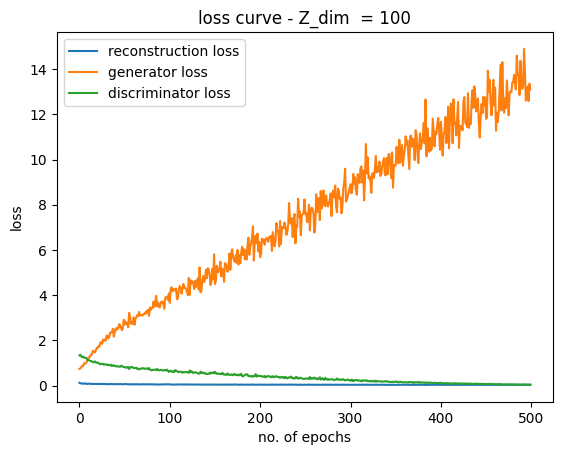

In [16]:
save_dir = "AAE/zdim = 100"
os.makedirs(save_dir,exist_ok= True)
save_path = os.path.join(save_dir, 'losscurve.png')                   

plt.plot(Reconstruction_loss)

plt.plot(Generator_loss)

plt.plot(Discriminator_loss)

plt.xlabel("no. of epochs")

plt.ylabel("loss")

plt.title("loss curve - Z_dim  = 100")

plt.legend(['reconstruction loss', 'generator loss', 'discriminator loss'])

plt.savefig(save_path)


In [17]:
#decoder.load_state_dict(torch.load("/home/ayushkumar1/Downloads/Ayush/Assignment2/AAE/trial2_zdim = 300/models/decoder3k_epoch299.pth", map_location= torch.device(device),weights_only=True))

(-0.5, 1301.5, 1301.5, -0.5)

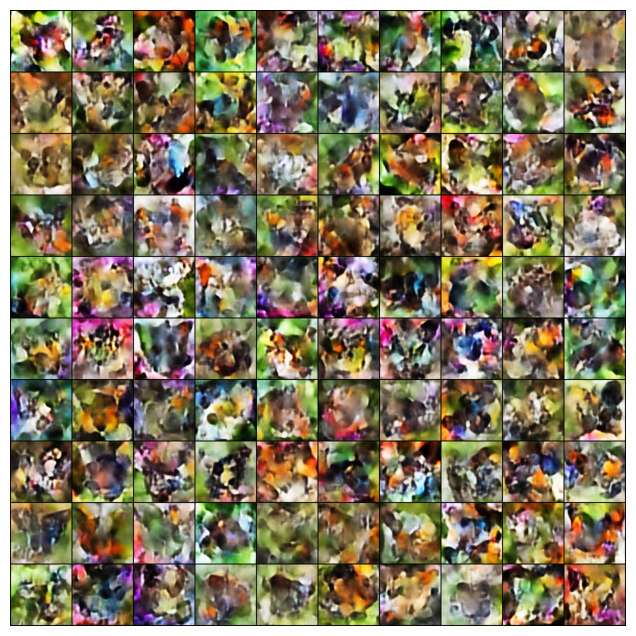

In [18]:
noise  = torch.randn(100, z_dim, 1, 1).to(device)
images = decoder(noise)
images.shape
images = images.cpu()  # Take the first image and add batch dimension

                    # Ensure the image is in the range [0, 1]

images = (images + 1) / 2.0  # Transform from [-1, 1] to [0, 1]

img = torchvision.utils.make_grid(images, normalize=False, nrow = 10)

img_np = img.detach().permute(1, 2, 0).numpy()  # Add detach() here

plt.figure(figsize=(8, 8))

plt.imshow(img_np)

plt.axis('off')